In [1]:
%reload_ext watermark
%matplotlib inline

import os
from scipy.stats import mannwhitneyu
from contextlib import suppress
from metapool.metapool import *
from metapool.util import (
    join_dfs_from_files, extend_sample_accession_df,
    extend_compression_layout_info, QIITA_STUDY_ID_KEY)
from metapool.plate import PlateReplication
from metapool import (make_sample_sheet, requires_dilution, dilute_gDNA,
                      find_threshold, autopool, add_controls, compress_plates, 
                      TUBECODE_KEY, SAMPLE_NAME_KEY)
from metapool.mp_strings import PM_SAMPLE_KEY
from metapool.sample_sheet import (
    STANDARD_METAG_SHEET_TYPE, ABSQUANT_SHEET_TYPE, make_sections_dict)
%watermark -i -v -iv -m -h -p metapool,sample_sheet,openpyxl -u

Last updated: 2024-08-28T11:26:02.586096-07:00

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.12.0

metapool    : 0+untagged.182.g3887998
sample_sheet: 0.13.0
openpyxl    : 3.1.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Hostname: C02G21EEMD6Q

seaborn   : 0.13.2
numpy     : 2.0.0
pandas    : 2.2.2
matplotlib: 3.9.0
re        : 2.2.1
json      : 2.0.9



# Knight Lab shotgun pipeline notebook

### What is it?

This Jupyter Notebook allows you to automatically produce most of the files you need for completing the Knight Lab shotgun sequencing pipeline.

Hopefully, this will not only make it much easier to generate these files, but also keep our information more accurate and tractable.

### Here's how it should work.

You'll start out with a **sample accession file**, which links each sample to it's appropriate matrix tube barcode. Then you'll read in the sample information from a Qiita metadata file. 

Next, you'll use a Compression Layout form to generate a 384-well dataframe of the sample well-locations and associated extraction plate metadata [`Project Name`, `Project Plate`, `Project Abbreviation`, `Plate elution volume`] The Compression Layout form will import 96-well plate layouts from **VisionMate plate reader output files**, and will assign a 384-well sample well-location based on the 384-well quadrant (`Plate Position`) each 96-well plate is occupying. Then, you'll compare the matrix tube barcodes in your 384-well plate with those stored in folders documenting control matrix tubes to automatically assign controls using the add_controls() function, followed by a validation step. 

Next, you will merge the sample gDNA concentration **quantification file** from the MiniPico assay, which will enable to you to automatically make a **normalization pick list** for starting the shotgun library prep itself. You can also visualize these concentrations on the plate, allowing you to double check the plate map and gDNA concentration read.

You'll then automatically assign barcodes to each sample by specifying a **plate counter**, producing a unique **index pick list** for barcode addition prior to PCR.

After finishing the shotgun library prep itself, you'll measure library concentration with the MiniPico assay. The sequencing library concentration **quantification file** will then be merged and used to estimate and visualize pooling parameters, producing a **pooling pick list**. 

Then, the per-sample information from the whole run can be combined to automatically produce **sample sheets** that you can use to demultiplex the sequencing data produced by Illumina sequencers. You'll need to specify the **sequencing platform** in order to produce an accurate sample sheet. 

Finally, you'll merge the sequence counts associated with each sample from a **sequence counts file** and produce a **sequence count normalized pooling pick list** for a final high output sequencing run. 

## Part 1 (of 4): Workflow for normalizing DNA

This portion of the notebook will read in the output of the mini-Pico quantification assay and construct an Echo normalization picklist file. 

As inputs, it requires:
1. A tab-delimited row-wise sample accession file that indicates the sample name (`sample_name`) and its associated matrix tube barcode (`TubeCode`)
2. A tab-delimited metadata file downloaded from Qiita
3. An accurate plate compression form, with appropriate VisionMate barcode scanner files (`Plate map file`)

The workflow then:
1. reads in the specified input files and constructs a dataframe
2. calculates volumes to be added via echo to reach desired input DNA quantity
3. produces an Echo-formatted pick list file

### Part 1 of 4, Step 0 of 8: Provide inputs

In [2]:
expt_name = "RKL4982"

In [3]:
# One dictionary per study included in the samples on this run.
studies_info = [
    # EVERY entry in the dictionary must be specifically updated 
    # *every* time this notebook is run--none of these have defaults!
    {
    'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
    'Project Abbreviation': 'ADAPT', # PROJECTNAME
    'sample_accession_fp': './test_data/Plate_Maps/sa_file_1.tsv',
    'qiita_metadata_fp': './test_data/Plate_Maps/12986_20230314-090655.txt',
    'experiment_design_description': 'isolate sequencing',
    'HumanFiltering': 'False', 
    'Email': 'r@gmail.com'
    },
    {
    'Project Name': 'CHILD_15510', # PROJECTNAME_QIITAID
    'Project Abbreviation': 'CHILD', # PROJECTNAME
    'sample_accession_fp': './test_data/Plate_Maps/sa_file_2.tsv',
    'qiita_metadata_fp': './test_data/Plate_Maps/15510_20240503-090339.txt',
    'experiment_design_description': 'whole genome sequencing',
    'HumanFiltering': 'True',
    'Email': 'l@ucsd.edu'
    },
    {
    'Project Name': 'Celeste_Marmoset_14577', # PROJECTNAME_QIITAID
    'Project Abbreviation': 'MARMO', # PROJECTNAME
    'sample_accession_fp': './test_data/Plate_Maps/sa_file_3.tsv',
    'qiita_metadata_fp': './test_data/Plate_Maps/14577_20230711-082202.txt',
    'experiment_design_description': 'whole genome sequencing',
    'HumanFiltering': 'False',
    'Email': 'c@ucsd.edu'
    }
]

In [4]:
# TODO: ask what you put in here when doing replicates
compression_layout = [
    {
        # top left plate
        'Plate Position': 1, # as int
        'Plate map file': './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_16_plate_map.tsv',
        'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_16', # Plate_#
        'Plate elution volume': 70
    },
    {
        # top right plate
        'Plate Position': 2, # as int
        'Plate map file': './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_17_plate_map.tsv',
        'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_17', # Plate_#
        'Plate elution volume': 70
    },
    {
        # bottom left plate
        'Plate Position': 3, # as int
        'Plate map file': './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_18_plate_map.tsv',
        'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_18', # Plate_#
        'Plate elution volume': 70
    },
    {
        # bottom right plate
        'Plate Position': 4, # as int
        'Plate map file': './test_data/Plate_Maps/CHILD_1000_plate_map.tsv',
        'Project Name': 'CHILD_15510', # PROJECTNAME_QIITAID    
        'Project Plate': 'Plate_1000',  # Plate_#
        'Plate elution volume': 70
    },
]

In [5]:
# CONSTANTS: Users, DO NOT CHANGE THESE
# values without consulting with tech team
SHEET_TYPE_VERSIONS = {
    STANDARD_METAG_SHEET_TYPE: '101',  # version supporting SampleContext
    ABSQUANT_SHEET_TYPE: '11'
}

BIOINFO_BASE = {
    'ForwardAdapter': 'GATCGGAAGAGCACACGTCTGAACTCCAGTCAC',
    'ReverseAdapter': 'GATCGGAAGAGCGTCGTGTAGGGAAAGGAGTGT',
    'library_construction_protocol': 'Knight Lab Kapa HyperPlus',
    # The BarcodesAreRC value is no longer used, but is still checked for
    # by the validation while making the sample sheet, so put in a dummy value
    'BarcodesAreRC': 'True'
}

WELL_COL = 'Well'
LIB_WELL_COL = 'Library Well'

# Mask arrays for even and odd rows and columns
EVEN_ROWS = [x for x in range(16) if x % 2 == 0]
ODD_ROWS = [x for x in range(16) if x % 2 == 1]
EVEN_COLS = [x for x in range(24) if x % 2 == 0]
ODD_COLS = [x for x in range(24) if x % 2 == 1]

In [6]:
def get_studies_attr_list(studies_dict, desired_key):
    return [x[desired_key] for x in studies_dict]

### Part 1 of 4, Step 1 of 8: Read in sample accession files

In [7]:
# read in the sample accession files
sample_accession_fps = get_studies_attr_list(
    studies_info, 'sample_accession_fp')
sample_accession_df = join_dfs_from_files(
    sample_accession_fps, [SAMPLE_NAME_KEY, TUBECODE_KEY])
sample_accession_df.shape

(3941, 2)

In [8]:
sample_accession_df.head()

,sample_name,TubeCode
0,23B.Day7.1,0359097394
1,23B.Day7.10,0359097402
2,23B.Day7.11,0359097385
3,23B.Day7.12,0359097375
4,23B.Day7.13,0359098882


### Part 1 of 4, Step 2 of 8: Read in the sample info from Qiita

In [9]:
# read in the qiita metadata files
qiita_metadata_fps = get_studies_attr_list(studies_info, 'qiita_metadata_fp')
metadata_df = join_dfs_from_files(
    qiita_metadata_fps, [SAMPLE_NAME_KEY, QIITA_STUDY_ID_KEY], 
    opt_cols_to_extract=['tube_id'], unique_cols=[SAMPLE_NAME_KEY])
metadata_df.shape

(8161, 3)

In [10]:
metadata_df.head()

,sample_name,qiita_study_id,tube_id
0,12986.23B.Day7.1,12986,23b-1_day7
1,12986.23B.Day7.10,12986,23b-10_day7
2,12986.23B.Day7.11,12986,23b-11_day7
3,12986.23B.Day7.12,12986,23b-12_day7
4,12986.23B.Day7.13,12986,23b-13_day7


Now use the metadata to link the study info into the sample accession dataframe:

In [11]:
extended_sample_accession_df = extend_sample_accession_df(
    sample_accession_df, studies_info, metadata_df)
extended_sample_accession_df.head()

,sample_name,TubeCode,Project Name,Project Abbreviation
0,23B.Day7.1,0359097394,Celeste_Adaptation_12986,ADAPT
1,23B.Day7.10,0359097402,Celeste_Adaptation_12986,ADAPT
2,23B.Day7.11,0359097385,Celeste_Adaptation_12986,ADAPT
3,23B.Day7.12,0359097375,Celeste_Adaptation_12986,ADAPT
4,23B.Day7.13,0359098882,Celeste_Adaptation_12986,ADAPT


### Part 1 of 4, Step 3 of 8: Assign the compression layout and add controls

In [12]:
# copy study info into the compression layout dictionary (so that it doesn't 
# have to be entered manually in both places)
extended_compression_layout = extend_compression_layout_info(
    compression_layout, studies_info)

In [13]:
plate_df = compress_plates(extended_compression_layout, 
                           extended_sample_accession_df, well_col=WELL_COL)
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,Time,TubeCode,Well,vol_extracted_elution_ul,well_id_96
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132553,A1,70,A1
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132554,A3,70,A2
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132555,A5,70,A3
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132556,A7,70,A4
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,0363132557,A9,70,A5


Check for samples with missing names; at this point, we expect all blanks
and katharoseq controls WON'T have names.

In [14]:
nas_mask = plate_df[PM_SAMPLE_KEY].isna()
plate_df[nas_mask].shape

(27, 15)

In [15]:
blanks_dir = './test_data/BLANKS'
# ATTENTION: Does your plate include katharoseq controls?
# If *yes*, replace the None below with the path to the directory they are in, such as
# katharoseq_dir = './test_data/katharoseq'
katharoseq_dir = None

plate_df = add_controls(plate_df, blanks_dir, katharoseq_dir)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1991: UserWarning: Controls added
  warnings.warn("Controls added")


After adding controls, check again for samples with missing names; 
at this point, we expect all blanks and katharoseq controls WILL have names, 
so if there are any remaining samples without names, 
stop processing and fix them!

In [16]:
plate_df[plate_df[PM_SAMPLE_KEY].isna()].shape

(0, 20)

In [17]:
plate_df[nas_mask]

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,Time,TubeCode,Well,vol_extracted_elution_ul,well_id_96,LocationCell,LocationColumn,LocationRow,description,Blank
346,BLANK.CHILD.1000.E11,11,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,E,09:30:11,0363159670,J22,70,E11,NaN,NaN,NaN,negative_control,True
347,BLANK.CHILD.1000.E12,12,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,E,09:30:11,0363159656,J24,70,E12,NaN,NaN,NaN,negative_control,True
348,BLANK.CHILD.1000.F1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,F,09:30:11,0363159647,L2,70,F1,NaN,NaN,NaN,negative_control,True
349,BLANK.CHILD.1000.F2,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,F,09:30:11,0363159609,L4,70,F2,NaN,NaN,NaN,negative_control,True
350,BLANK.CHILD.1000.F3,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,F,09:30:11,0363159623,L6,70,F3,NaN,NaN,NaN,negative_control,True
351,BLANK.CHILD.1000.F4,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,F,09:30:11,0363159600,L8,70,F4,NaN,NaN,NaN,negative_control,True
363,BLANK.CHILD.1000.G4,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,G,09:30:11,0363238857,N8,70,G4,NaN,NaN,NaN,negative_control,True
364,BLANK.CHILD.1000.G5,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,G,09:30:11,0363238864,N10,70,G5,NaN,NaN,NaN,negative_control,True
365,BLANK.CHILD.1000.G6,6,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,G,09:30:11,0363238872,N12,70,G6,NaN,NaN,NaN,negative_control,True
366,BLANK.CHILD.1000.G7,7,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,G,09:30:11,0363238880,N14,70,G7,NaN,NaN,NaN,negative_control,True


### Part 1 of 4, Step 4 of 8: Validate plate dataframe

In [18]:
# note that this function does not *need* the extended sample accession df,
# but it is easier to use it just to keep things consistent
validate_plate_df(plate_df,metadata_df, extended_sample_accession_df, 
                  blanks_dir, katharoseq_dir)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2040: UserWarning: There are 27 control samples in this plate
  warnings.warn(f"There are {len(control_samples)} control samples"
/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2051: UserWarning: There are 357 samples with associated metadata in this plate
  warnings.warn(
/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2061: UserWarning: All samples have associated metadata :D
  warnings.warn("All samples have associated metadata :D")
/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2110: UserWarning: All TubeCodes have associated data :D
  warnings.warn("All TubeCodes have associated data :D")


### Part 1 of 4, Step 5 of 8: read in DNA concentrations and add to plate map

**Enter the correct path to the Pico DNA concentration output**. This should be
 a tab-separated file produced by the MiniPico assay on the condensed, 
 384-well plate, and should have a format like the below:

```
##BLOCKS= 1
Group: Unknowns
Sample	Wells	RFU_Values	Concentration	Mean_Conc	SD	CV	Dilution	AdjConc	
01	A1	528791.000	2.472	2.472	0.000	0.0			
02	C1	481728.000	2.282	2.282	0.000	0.0			
03	E1	462964.000	2.206	2.206	0.000	0.0			
04	G1	556609.000	2.585	2.585	0.000	0.0			
05	I1	710679.000	3.207	3.207	0.000	0.0			
06	K1	655693.000	2.985	2.985	0.000	0.0		
```

In [19]:
sample_concs_fp = './test_data/Quant/MiniPico/2022_07_Celeste_Adaptation_16_17_18_21_gDNA_quant.txt'

if not os.path.isfile(sample_concs_fp):
    print("Problem! %s is not a path to a valid file" % sample_concs_fp)
sample_concs = read_pico_csv(sample_concs_fp, plate_reader='SpectraMax_i3x')
sample_concs.head()

,Well,Sample DNA Concentration
0,A1,2.472
1,C1,2.282
2,E1,2.206
3,G1,2.585
4,I1,3.207


In [20]:
plate_df = pd.merge(plate_df, sample_concs, on=WELL_COL)
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,TubeCode,Well,vol_extracted_elution_ul,well_id_96,LocationCell,LocationColumn,LocationRow,description,Blank,Sample DNA Concentration
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,0363132553,A1,70,A1,NaN,NaN,NaN,NaN,False,2.472
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,0363132554,A3,70,A2,NaN,NaN,NaN,NaN,False,2.735
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,0363132555,A5,70,A3,NaN,NaN,NaN,NaN,False,2.988
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,0363132556,A7,70,A4,NaN,NaN,NaN,NaN,False,1.995
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,0363132557,A9,70,A5,NaN,NaN,NaN,NaN,False,1.457


In [21]:
if requires_dilution(plate_df,threshold=10,tolerance=.10):
    plate_df = dilute_gDNA(plate_df,threshold=10)
    print('You need to make a 1:10 gDNA dilution plate.')
else:
    plate_df['extracted_gdna_concentration_ng_ul'] = \
        plate_df['Sample DNA Concentration'].copy()
    plate_df['Diluted'] = False
    print('Proceed w/out gDNA dilutions')

Proceed w/out gDNA dilutions



**Visualize plate DNA concentrations and plate map:**

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


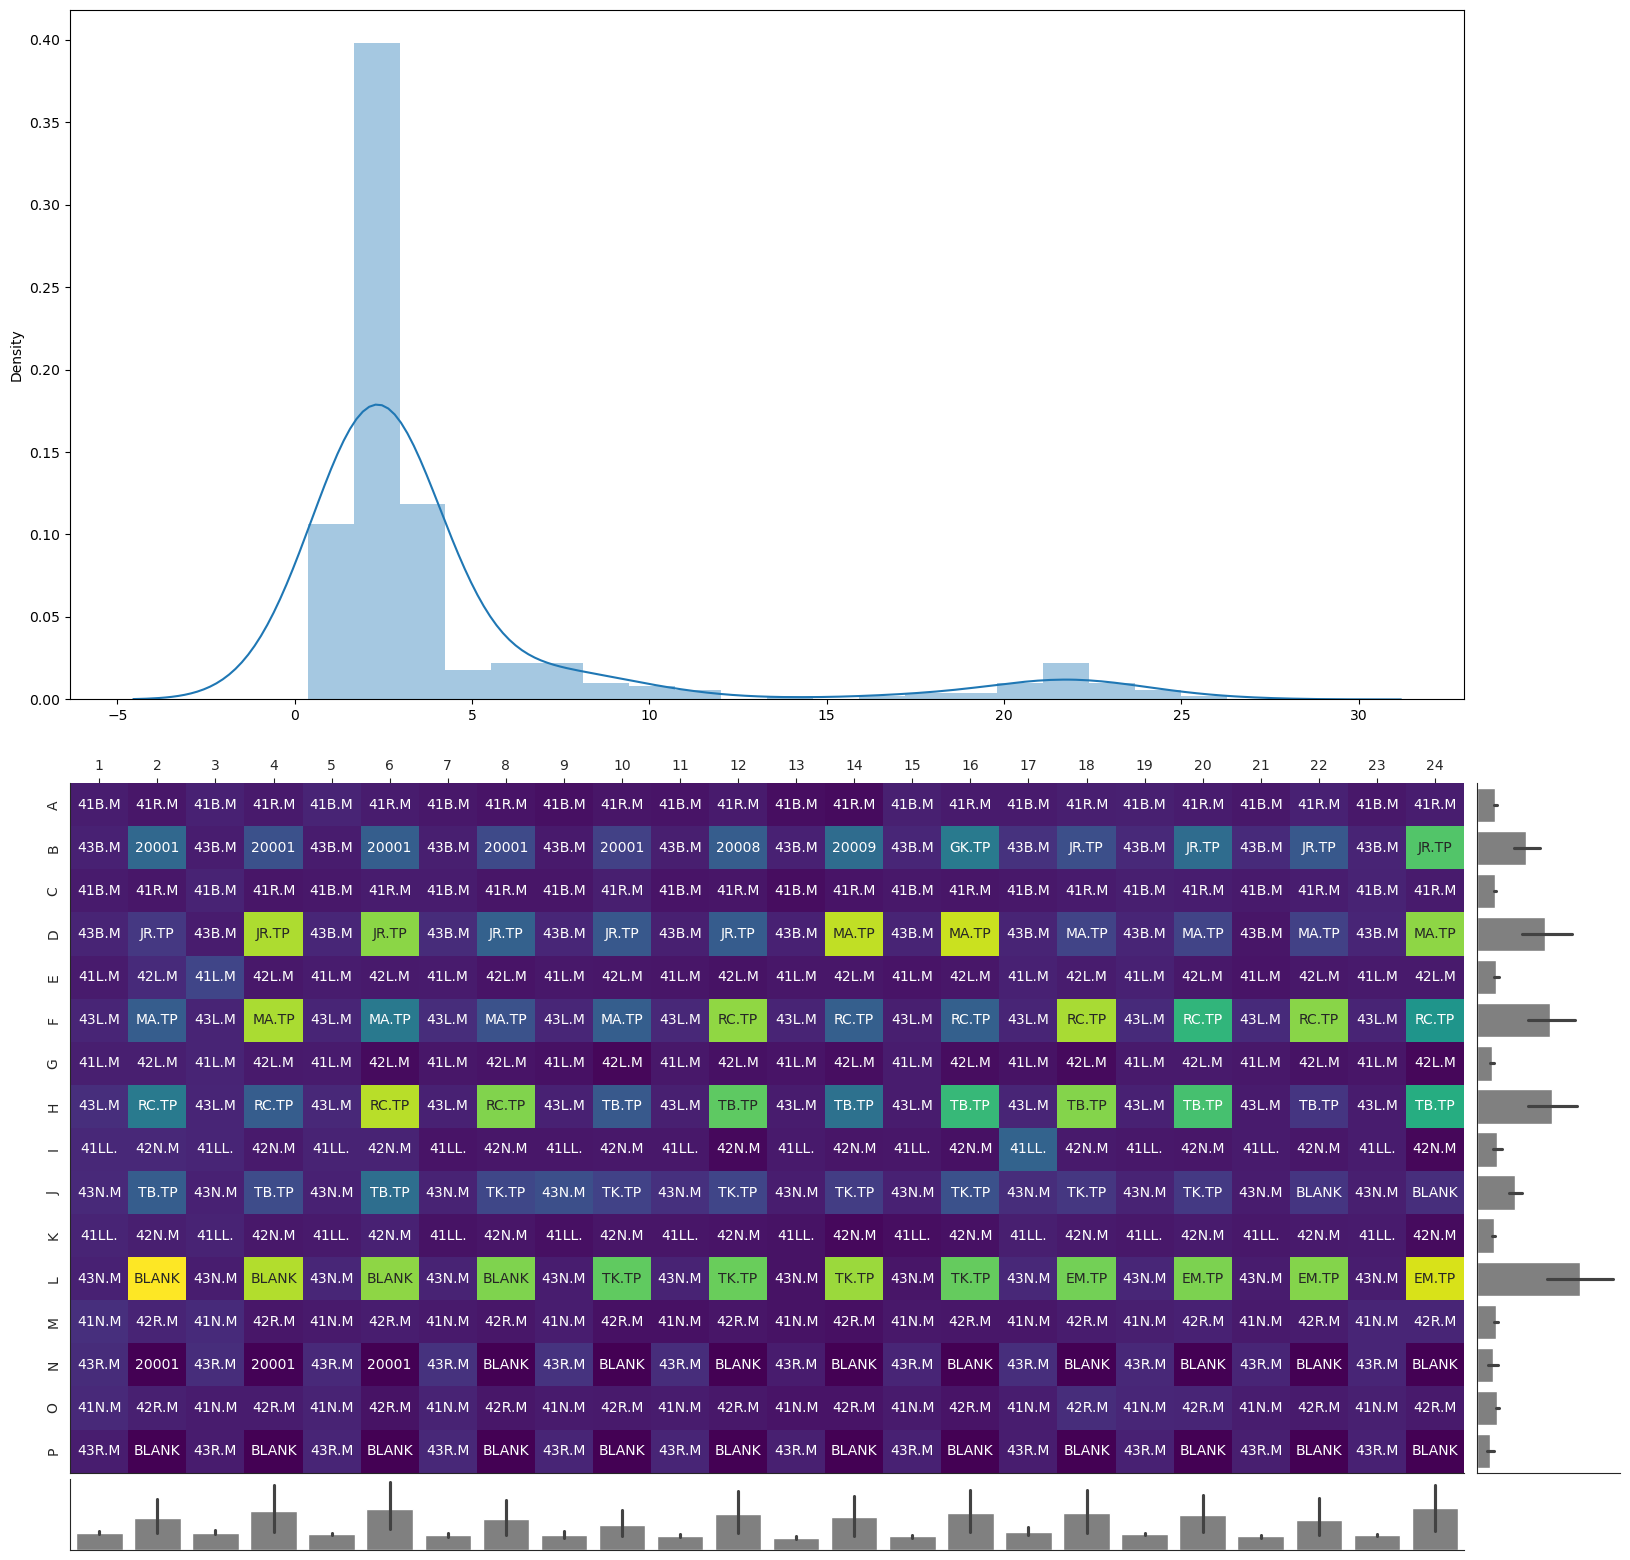

In [22]:
# get DNA concentration information
dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', 
                          well_col=WELL_COL).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col=PM_SAMPLE_KEY, well_col=WELL_COL)

plot_plate_vals(dna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')

#### Make sample replicates

Set replicate dictionary, if needed.

In [23]:
# Replicate formats:
# replicate_dict = {source1_quadrant:destination1_quadrant}
# replicate_dict = {source1_quadrant:[destination1_quadrants,destination1_quadrants]}
# Replicate example: 
# replicate_dict = {1:[2,3]}
# for no replicates, use:
replicate_dict = None

# 'Well' differs from 'Library Well' because the former specifies the 
# gDNA source well while the latter specifies the well (destination well) that 
# will contain the sequencing library for the sample. These contain the same
# info when replicates are not used, but differ when replicates ARE used,
# so it is safer to use 'Library Well' in both cases.
# (Careful!  well_col is a global variable used throughout rest of notebook)
well_col = LIB_WELL_COL

In [24]:
# initialize new PlateReplication object to manage metadata, conversions, etc.
# initialize w/preferred well_col.
pr = PlateReplication(well_col)

# set overwrite=False to detect any overwriting of source or destination quads 
# and raise an Error.
plate_df = pr.make_replicates(
    plate_df, replicates=replicate_dict, overwrite=True)

# replicates overlapping sample_wells for other samples should raise warning,
# but will be allowed
if 'True' in plate_df['contains_replicates'].unique():
    plate_df['contains_replicates'] = True
    # get DNA concentration information
    dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', 
                              well_col=well_col).astype(float)

    # get information for annotation
    names = make_2D_array(plate_df, data_col=PM_SAMPLE_KEY, well_col=well_col)

    plot_plate_vals(dna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.6s')
else:
    plate_df['contains_replicates'] = False
    
# show whether this plate contains replicates or not
f"Contains replicates: {plate_df['contains_replicates'].unique()}"

'Contains replicates: [False]'

#### gDNA concentration heatmap, Plate 1

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


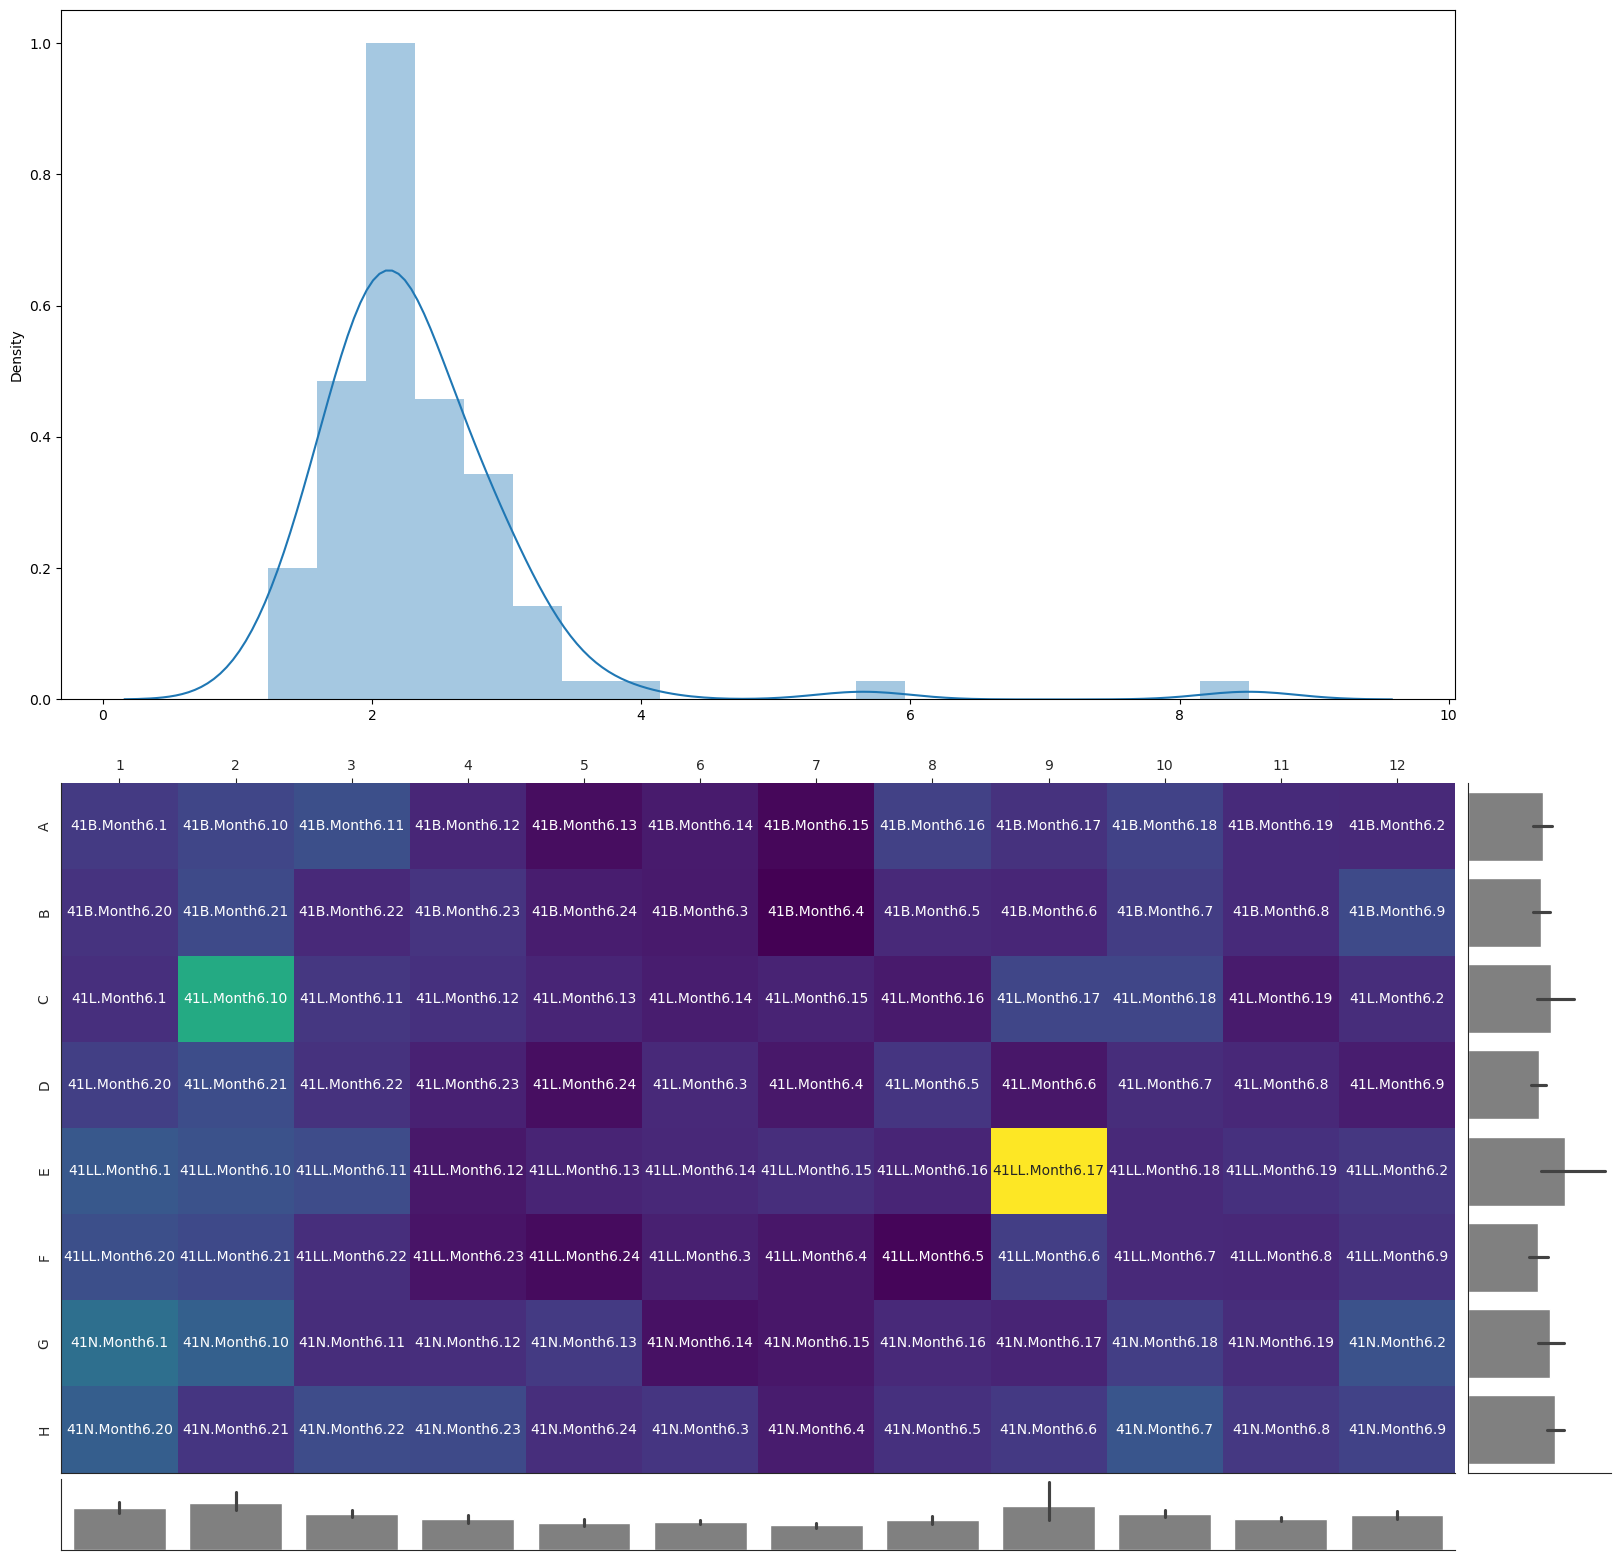

In [25]:
plot_plate_vals(dna_concs[np.ix_(EVEN_ROWS,EVEN_COLS)],
                annot_str= names[np.ix_(EVEN_ROWS,EVEN_COLS)],
                color_map='viridis',
                annot_fmt='')

#### gDNA concentration heatmap, Plate 2

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


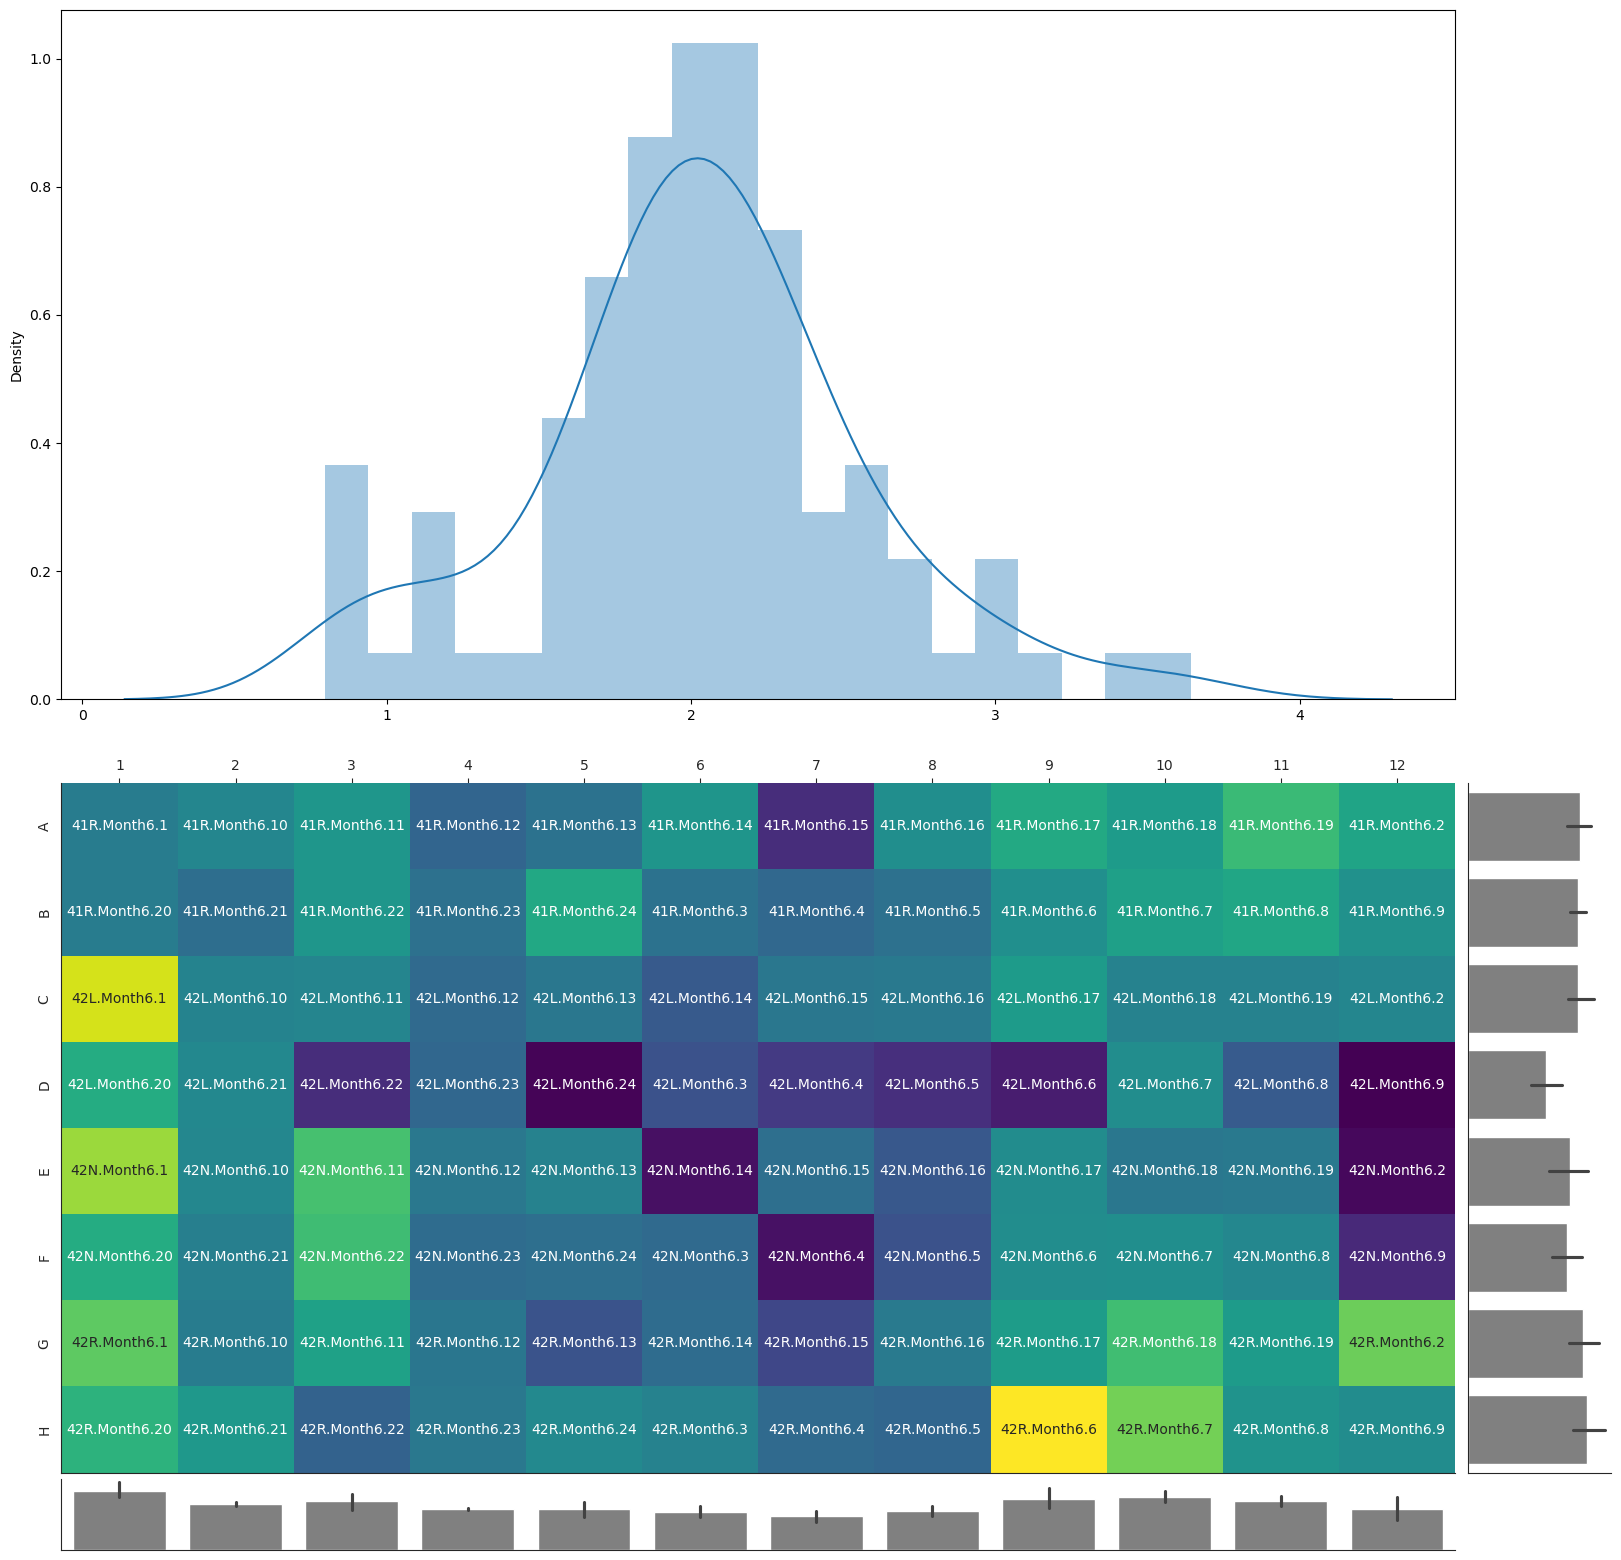

In [26]:
plot_plate_vals(dna_concs[np.ix_(EVEN_ROWS,ODD_COLS)],
                    annot_str= names[np.ix_(EVEN_ROWS,ODD_COLS)],
                    color_map='viridis',
                    annot_fmt='')

#### gDNA concentration heatmap, Plate 3

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


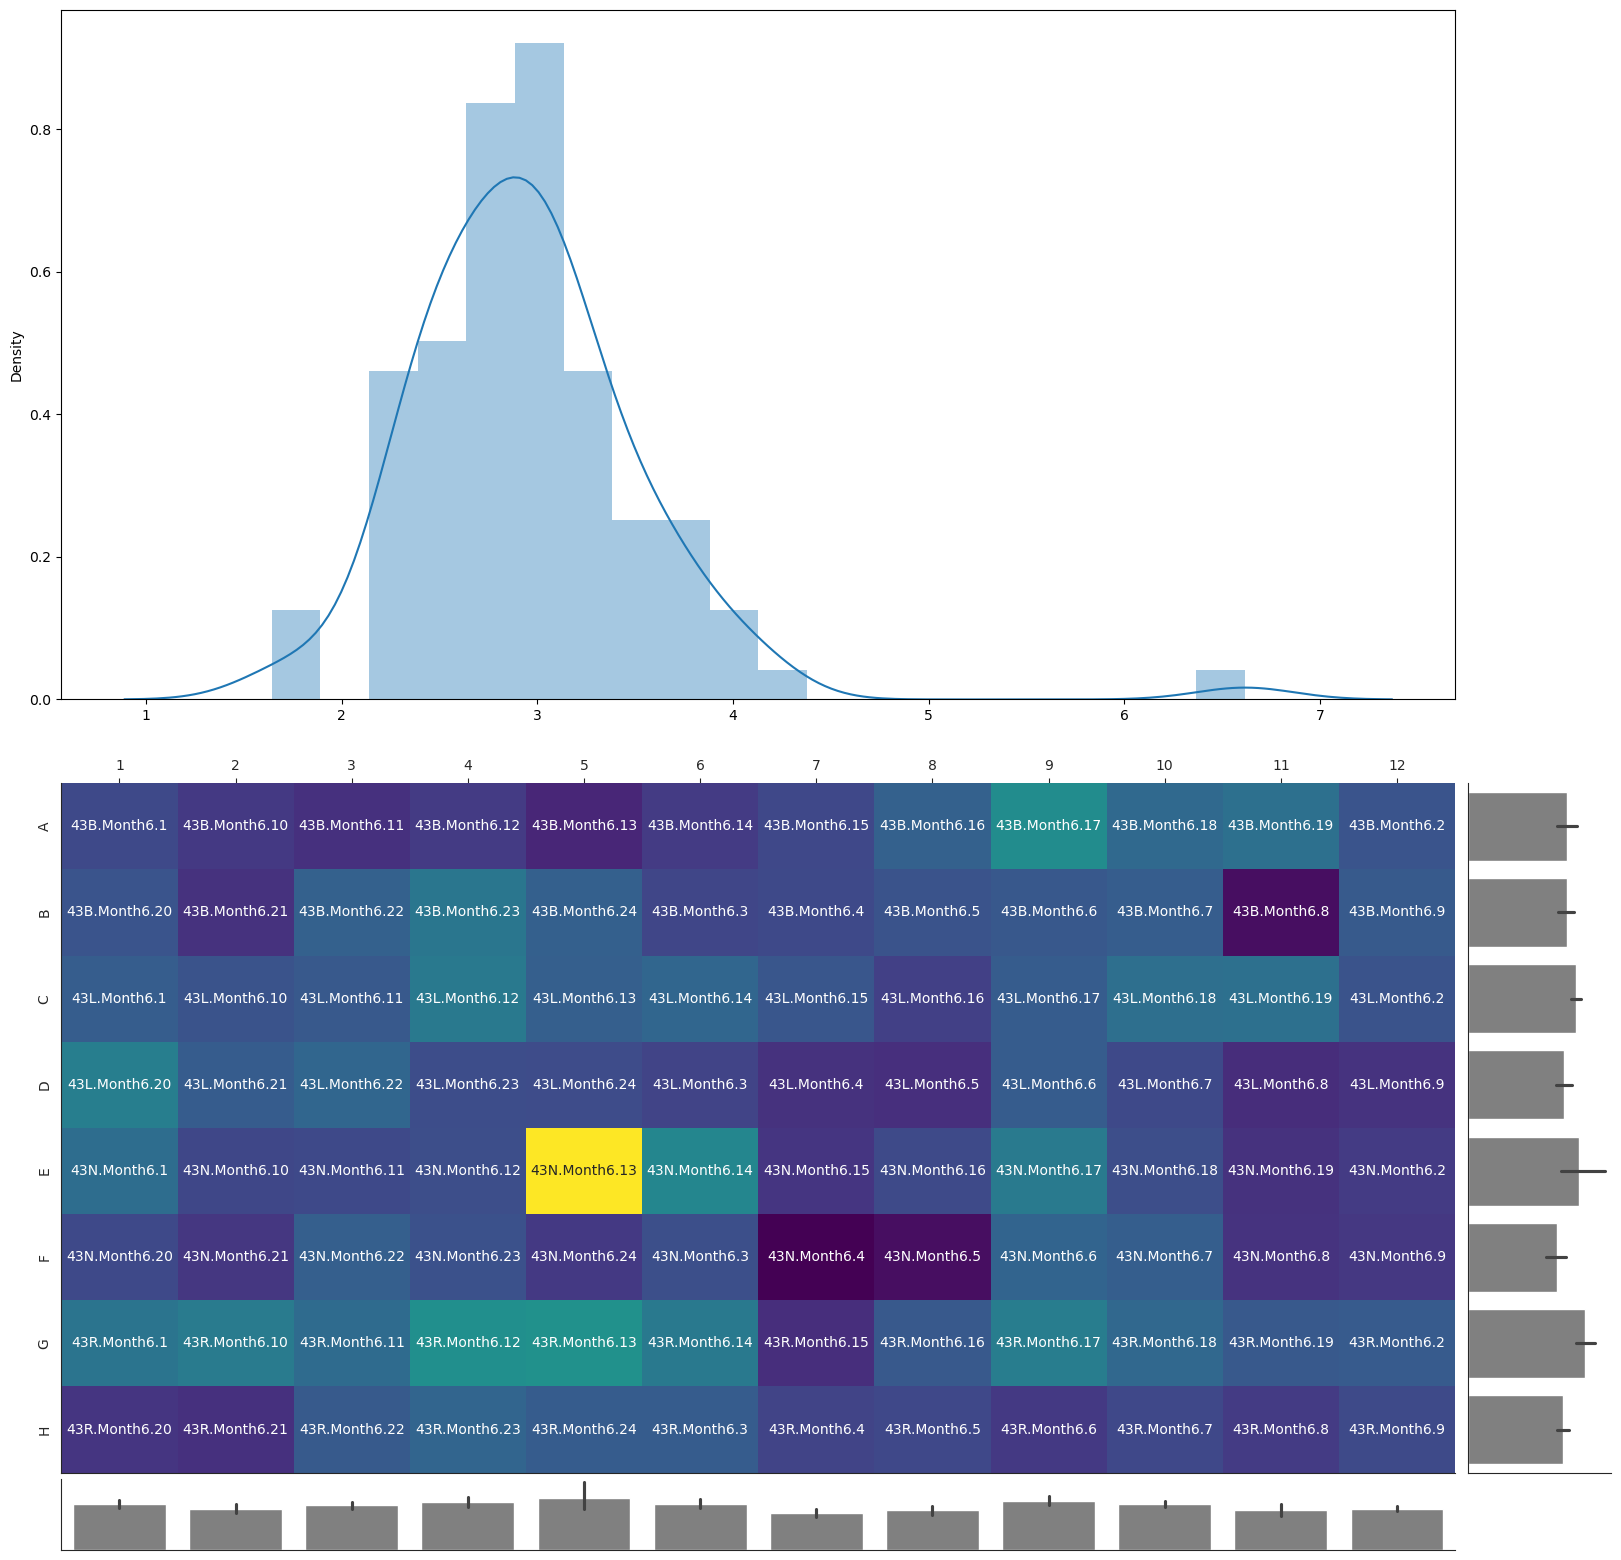

In [27]:
plot_plate_vals(dna_concs[np.ix_(ODD_ROWS,EVEN_COLS)],
                    annot_str= names[np.ix_(ODD_ROWS,EVEN_COLS)],
                    color_map='viridis',
                    annot_fmt='')


#### gDNA concentration heatmap, Plate 4

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


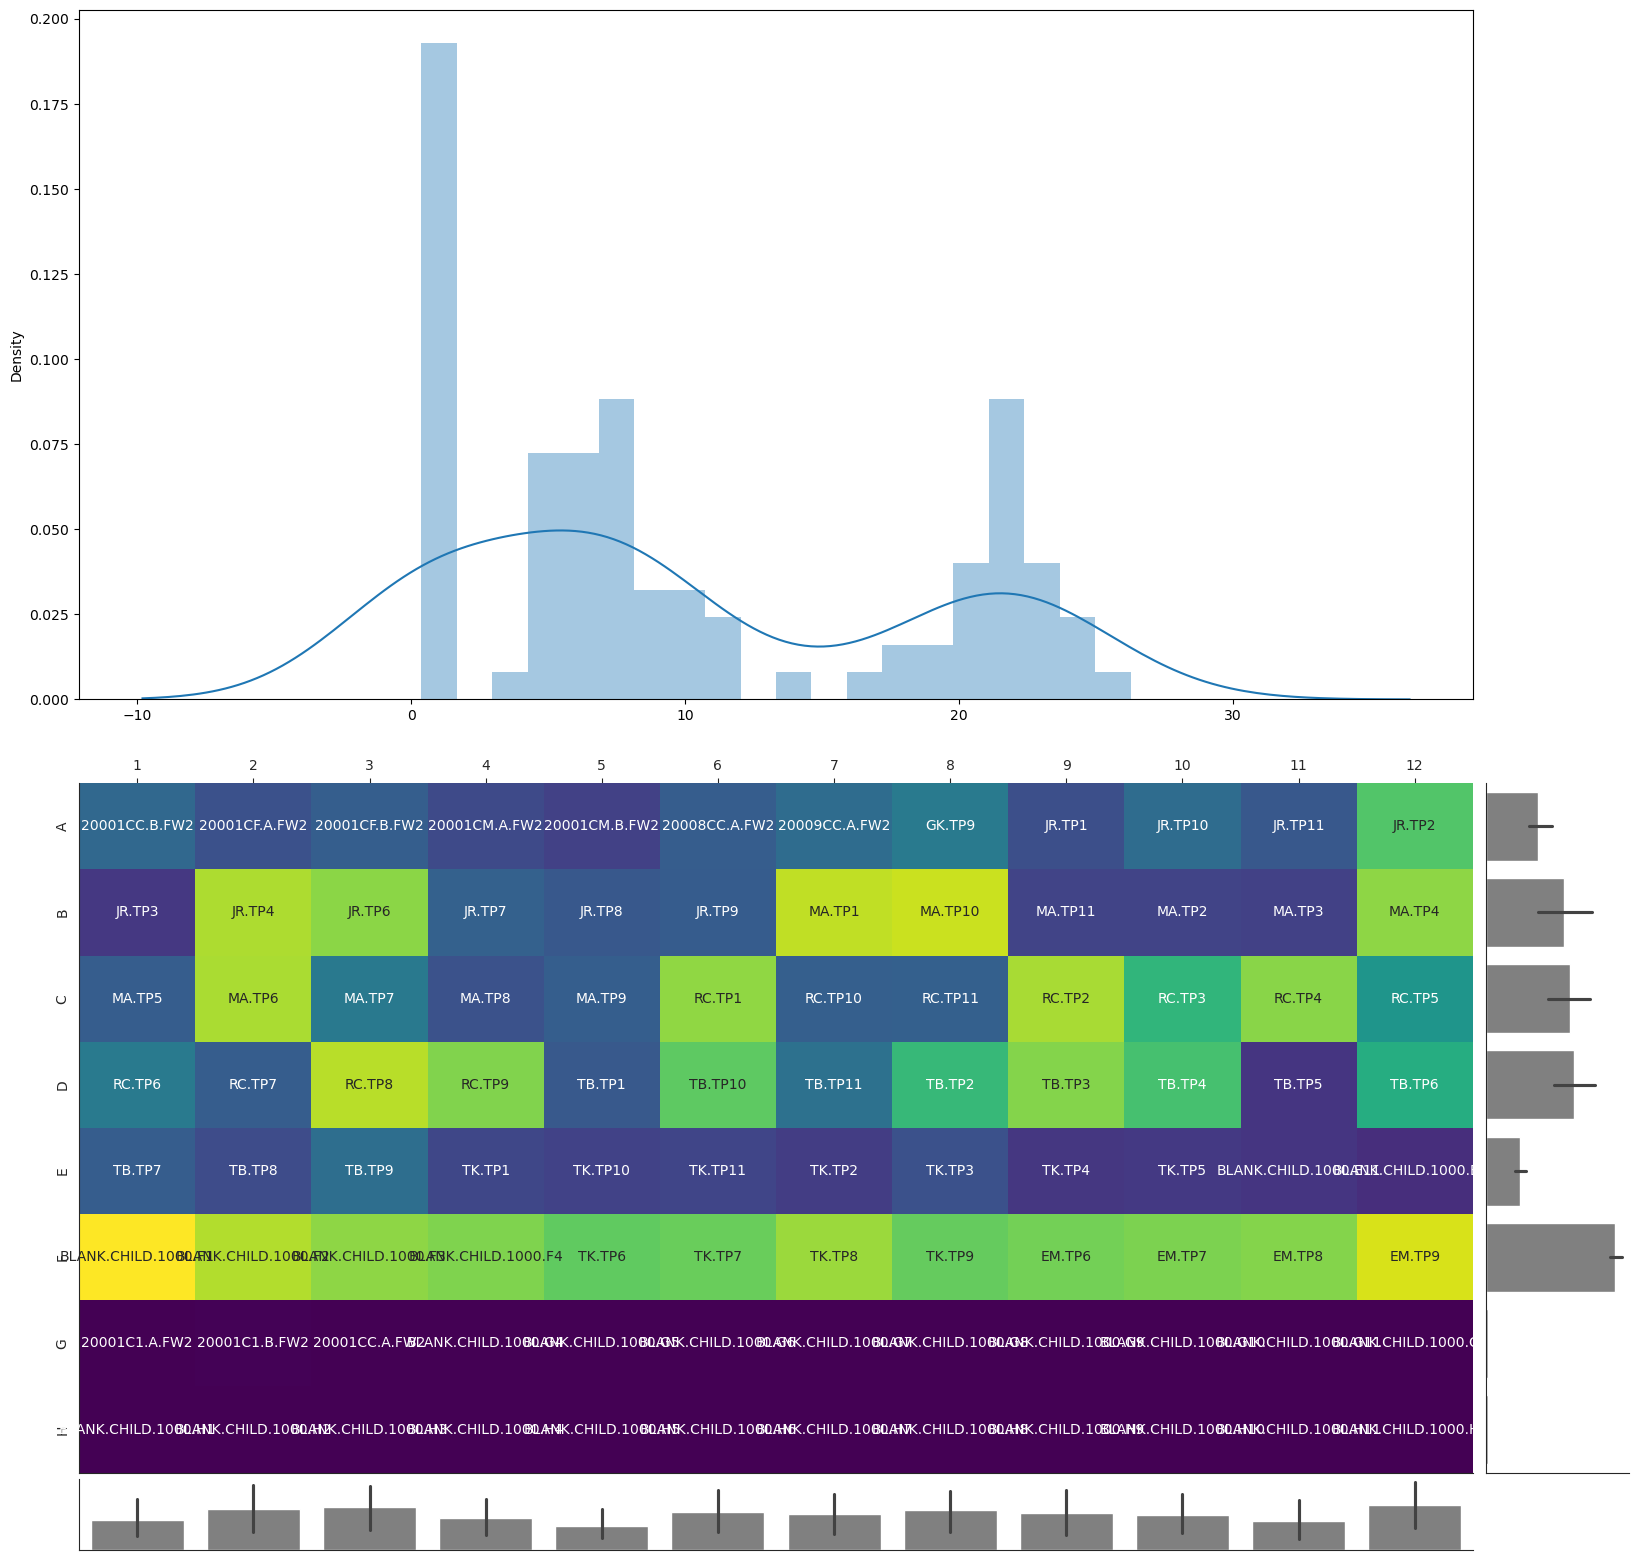

In [28]:
plot_plate_vals(dna_concs[np.ix_(ODD_ROWS,ODD_COLS)],
                    annot_str= names[np.ix_(ODD_ROWS,ODD_COLS)],
                    color_map='viridis',
                    annot_fmt='')

### Part 1 of 4, Step 6 of 8: calculate normalization volumes and add to plate map

This step will calculate volumes for the DNA normalization pick list.

Check the desired values for:
 - **`ng`**: the desired quantity of DNA in normed plate, in ng
 - **`total_vol`**: the total volume of normalized DNA, in nL
 - **`min_vol`**: the minimum quantity of sample to add, in nL
 - **`resolution`**: the resolution of the Echo, in nL (usually 2.5)

In [29]:
ng = 5
total_vol = 3500
min_vol = 25
resolution = 2.5

dna_vols = calculate_norm_vol(
    plate_df['Sample DNA Concentration'], ng=ng, min_vol=min_vol, 
    max_vol=total_vol, resolution=resolution)
water_vols = total_vol - dna_vols

plate_df['Normalized DNA volume'] = dna_vols
plate_df['Normalized water volume'] = water_vols

plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,LocationRow,description,Blank,Sample DNA Concentration,extracted_gdna_concentration_ng_ul,Diluted,Library Well,contains_replicates,Normalized DNA volume,Normalized water volume
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,False,2.472,2.472,False,A1,False,2022.5,1477.5
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,False,2.735,2.735,False,A3,False,1827.5,1672.5
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,False,2.988,2.988,False,A5,False,1672.5,1827.5
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,False,1.995,1.995,False,A7,False,2507.5,992.5
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,False,1.457,1.457,False,A9,False,3432.5,67.5


### Part 1 of 4, Step 7 of 8 (optional): Add synDNA spike-in

In [30]:
# Set syndna_pool_number to 1 if syndna is being used; otherwise, leave as None
syndna_pool_number = None
plate_df = add_syndna(plate_df, 
                      syndna_pool_number=syndna_pool_number,
                      syndna_concentration=2.22)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1596: UserWarning: Returning input plate dataframe;no synDNA will be added to this prep
  warnings.warn("Returning input plate dataframe;"


In [31]:
def is_absquant(a_plate_df):
    return bool(np.any(a_plate_df['syndna_pool_number'].unique()))

In [32]:
f'For this plate, is_absquant = {is_absquant(plate_df)}'


'For this plate, is_absquant = False'

In [33]:
if is_absquant(plate_df):
    syndna_well='A1'
    syndna_plate = 'synDNA plate'
    syndna_picklist = \
        format_dna_norm_picklist(
            np.array(plate_df['synDNA volume']),
            np.zeros(plate_df.shape[0]),
            np.repeat(syndna_well,plate_df.shape[0]),
            dest_wells = np.array(plate_df[well_col]),
            sample_names = np.array(plate_df[PM_SAMPLE_KEY]),
            sample_plates = np.repeat(syndna_plate,plate_df.shape[0]))

In [34]:
if is_absquant(plate_df):
    # Write the picklist as .txt
    syndna_picklist_fp = './test_output/Input_Norm/YYYY_MM_DD_Celeste_Adaptation_16-21_syndna.txt'

    if os.path.isfile(syndna_picklist_fp):
        print("Warning! This file exists already.")

In [35]:
if is_absquant(plate_df):
    with open(syndna_picklist_fp, 'w') as f:
        f.write(syndna_picklist)

    !head {syndna_picklist_fp}

### Part 1 of 4, Step 8 of 8: Make pick list and write to file

Format the Echo-compatible pick list.

In [36]:
norm_picklist = format_dna_norm_picklist(
    np.array(plate_df['Normalized DNA volume']),
    np.array(plate_df['Normalized water volume']),
    np.array(plate_df['Well']),
    dest_wells = np.array(plate_df[well_col]),
    sample_names = np.array(plate_df[PM_SAMPLE_KEY]),
    sample_plates = np.array(plate_df['Compressed Plate Name']),
    dna_concs = np.array(plate_df['Sample DNA Concentration']))

In [37]:
# Write the picklist as .txt
norm_picklist_fp = './test_output/Input_Norm/YYYY_MM_DD_Celeste_Adaptation_16-21_inputnorm.txt'

if os.path.isfile(norm_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [38]:
with open(norm_picklist_fp, 'w') as f:
    f.write(norm_picklist)
    
!head {norm_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Concentration	Transfer Volume	Destination Plate Name	Destination Well
41B.Month6.1	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A1	2.472	2022.5	NormalizedDNA	A1
41B.Month6.10	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A3	2.735	1827.5	NormalizedDNA	A3
41B.Month6.11	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A5	2.988	1672.5	NormalizedDNA	A5
41B.Month6.12	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A7	1.995	2507.5	NormalizedDNA	A7
41B.Month6.13	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A9	1.457	3432.5	NormalizedDNA	A9
41B.Month6.14	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A11	1.752	2855.0	NormalizedDNA	A11
41B.Month6.15	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A13	1.34	3500.0	NormalizedDNA	A13
41B.Month6.16	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A15	2.637	1895.0	N

## Part 2 (of 4): Workflow for assigning barcodes

This portion of the notebook will assign index values and construct an Echo picklist file for adding barcodes. 

As inputs, it requires:
1. A plate_df dataframe (from previous step)
2. A tab-delimited index combination file, relating index combinations, i5 and i7 index values, and i5 and i7 index locations

The workflow then:
1. reads in the index combo list
2. assigns indices per sample
3. produces an Echo-formatted pick list file

### Part 2 of 4, Step 1 of 3: Read in index combo list

This is a file that contains every possible i5 and i7 barcode combo on a separate line,
along with plate and well location information. It should look something like this:

```
index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,ACCGACAAACGTTACC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate
1,AGTGGCAACTGTGTTG,iTru5_01_B,AGTGGCAA,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate
2,CACAGACTTGAGGTGT,iTru5_01_C,CACAGACT,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate
3,CGACACTTGATCCATG,iTru5_01_D,CGACACTT,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate
4,GACTTGTGGCCTATCA,iTru5_01_E,GACTTGTG,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate
5,GTGAGACTAACAACCG,iTru5_01_F,GTGAGACT,F1,iTru5_plate,iTru7_101_06,AACAACCG,A6,iTru7_plate
6,GTTCCATGACTCGTTG,iTru5_01_G,GTTCCATG,G1,iTru5_plate,iTru7_101_07,ACTCGTTG,A7,iTru7_plate
7,TAGCTGAGCCTATGGT,iTru5_01_H,TAGCTGAG,H1,iTru5_plate,iTru7_101_08,CCTATGGT,A8,iTru7_plate
8,CTTCGCAATGTACACC,iTru5_02_A,CTTCGCAA,I1,iTru5_plate,iTru7_101_09,TGTACACC,A9,iTru7_plate
```

In [39]:
index_combo_fp = './test_output/iTru/new_iTru_combos_Dec2017.csv'

if not os.path.isfile(index_combo_fp):
    print("Problem! %s is not a path to a valid file" % index_combo_fp)

In [40]:
# TODO: check if changing to set dtype = str causes issues
#  needs to be cast after reading in the file
index_combos = pd.read_csv(index_combo_fp)
index_combos.head()

,index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,0,ACCGACAAACGTTACC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate
1,1,CTTCGCAACTGTGTTG,iTru5_02_A,CTTCGCAA,A3,iTru5_plate,iTru7_101_02,CTGTGTTG,A3,iTru7_plate
2,2,AACACCACTGAGGTGT,iTru5_03_A,AACACCAC,A5,iTru5_plate,iTru7_101_03,TGAGGTGT,A5,iTru7_plate
3,3,CGTATCTCGATCCATG,iTru5_04_A,CGTATCTC,A7,iTru5_plate,iTru7_101_04,GATCCATG,A7,iTru7_plate
4,4,GGTACGAAGCCTATCA,iTru5_05_A,GGTACGAA,A9,iTru5_plate,iTru7_101_05,GCCTATCA,A9,iTru7_plate


### Part 2 of 4, Step 2 of 3: Assign index combo

This will pick a set of index combos from the index combo for the number of samples in the `plate_df` DataFrame.

Keep track of the barcode combinations used in the lab, and set `starting_combo` equal to the next unused combination.

One of way of doing that might be to keep track of the number of plates run, and set `starting_combo` equal to
384 * number of plates run + 1.

In [41]:
plate_counter = 144
starting_combo = ((plate_counter - 1) % 384) * 384

indices = assign_index(len(plate_df[PM_SAMPLE_KEY]), index_combos, 
                       start_idx=starting_combo).reset_index()

plate_df = pd.concat([plate_df, indices], axis=1)
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,54912,ACCGACAAACGATGAC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_112_12,ACGATGAC,G24,iTru7_plate
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,54913,CTTCGCAACGTTATGC,iTru5_02_A,CTTCGCAA,A3,iTru5_plate,iTru7_113_01,CGTTATGC,I2,iTru7_plate
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,54914,AACACCACGATACTGG,iTru5_03_A,AACACCAC,A5,iTru5_plate,iTru7_113_02,GATACTGG,I4,iTru7_plate
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,54915,CGTATCTCCTACTTGG,iTru5_04_A,CGTATCTC,A7,iTru5_plate,iTru7_113_03,CTACTTGG,I6,iTru7_plate
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,54916,GGTACGAACATACCAC,iTru5_05_A,GGTACGAA,A9,iTru5_plate,iTru7_113_04,CATACCAC,I8,iTru7_plate


### Part 2 of 4, Step 3 of 3: Make index pick list and write to file

Format the Echo-compatible pick list.

In [42]:
index_picklist = format_index_picklist(
    plate_df[PM_SAMPLE_KEY], plate_df[well_col], indices)

In [43]:
# Write the picklist as .txt
index_picklist_fp = './test_output/Indices/YYYY_MM_DD_Celeste_Adaptation_16-21_indices_matrix.txt'

if os.path.isfile(index_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [44]:
with open(index_picklist_fp, 'w') as f:
    f.write(index_picklist)

!head {index_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Transfer Volume	Index Name	Index Sequence	Index Combo	Destination Plate Name	Destination Well
41B.Month6.1	iTru5_plate	384LDV_AQ_B2	A1	250	iTru5_01_A	ACCGACAA	54912	IndexPCRPlate	A1
41B.Month6.10	iTru5_plate	384LDV_AQ_B2	A3	250	iTru5_02_A	CTTCGCAA	54913	IndexPCRPlate	A3
41B.Month6.11	iTru5_plate	384LDV_AQ_B2	A5	250	iTru5_03_A	AACACCAC	54914	IndexPCRPlate	A5
41B.Month6.12	iTru5_plate	384LDV_AQ_B2	A7	250	iTru5_04_A	CGTATCTC	54915	IndexPCRPlate	A7
41B.Month6.13	iTru5_plate	384LDV_AQ_B2	A9	250	iTru5_05_A	GGTACGAA	54916	IndexPCRPlate	A9
41B.Month6.14	iTru5_plate	384LDV_AQ_B2	A11	250	iTru5_06_A	CGATCGAT	54917	IndexPCRPlate	A11
41B.Month6.15	iTru5_plate	384LDV_AQ_B2	A13	250	iTru5_07_A	AAGACACC	54918	IndexPCRPlate	A13
41B.Month6.16	iTru5_plate	384LDV_AQ_B2	A15	250	iTru5_08_A	CATCTGCT	54919	IndexPCRPlate	A15
41B.Month6.17	iTru5_plate	384LDV_AQ_B2	A17	250	iTru5_09_A	CTCTCAGA	54920	IndexPCRPlate	A17


## Part 3 (of 4): Workflow for calculating pooling

This portion of the notebook calculates pooling based on fluorescent
 quantification values and produces visual outputs to interpret and check 
 values. 

As inputs, this workflow requires:
1. A plate map DataFrame (from previous step)
2. MiniPico output (tab-delimited text format with columns 'Concentration' and 'Well')

The workflow:
1. reads in MiniPico output and calculates estimated library concentration
2. calculates pooling values and generates an Echo pick list

### Part 3 of 4, Step 1 of 7: read in MiniPico library concentration
Enter correct path to MiniPico file:

In [45]:
lib_concs_fp = './test_data/Quant/MiniPico/2022_07_Celeste_Adaptation_16_17_18_21_CleanLib_quant.txt'

In [46]:
lib_concs = read_pico_csv(lib_concs_fp, plate_reader='SpectraMax_i3x',
                          conc_col_name='MiniPico Library DNA Concentration')
lib_concs.rename(columns={'Well':well_col},inplace=True)
plate_df = pd.merge(plate_df, lib_concs, on=well_col)

plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,MiniPico Library DNA Concentration
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,ACCGACAAACGATGAC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_112_12,ACGATGAC,G24,iTru7_plate,0.566
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,CTTCGCAACGTTATGC,iTru5_02_A,CTTCGCAA,A3,iTru5_plate,iTru7_113_01,CGTTATGC,I2,iTru7_plate,0.680
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,AACACCACGATACTGG,iTru5_03_A,AACACCAC,A5,iTru5_plate,iTru7_113_02,GATACTGG,I4,iTru7_plate,0.868
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,CGTATCTCCTACTTGG,iTru5_04_A,CGTATCTC,A7,iTru5_plate,iTru7_113_03,CTACTTGG,I6,iTru7_plate,0.740
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,GGTACGAACATACCAC,iTru5_05_A,GGTACGAA,A9,iTru5_plate,iTru7_113_04,CATACCAC,I8,iTru7_plate,1.431


### Part 3 of 4, Step 2 of 7: calculate sample concentration from MiniPico

You will want to make sure that 'size' is correct for your average library size.

In [47]:
plate_df['MiniPico Library Concentration'] = \
    compute_pico_concentration(
        plate_df['MiniPico Library DNA Concentration'], size=500)
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,MiniPico Library DNA Concentration,MiniPico Library Concentration
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_112_12,ACGATGAC,G24,iTru7_plate,0.566,1.715152
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,iTru5_02_A,CTTCGCAA,A3,iTru5_plate,iTru7_113_01,CGTTATGC,I2,iTru7_plate,0.680,2.060606
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,iTru5_03_A,AACACCAC,A5,iTru5_plate,iTru7_113_02,GATACTGG,I4,iTru7_plate,0.868,2.630303
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,iTru5_04_A,CGTATCTC,A7,iTru5_plate,iTru7_113_03,CTACTTGG,I6,iTru7_plate,0.740,2.242424
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,iTru5_05_A,GGTACGAA,A9,iTru5_plate,iTru7_113_04,CATACCAC,I8,iTru7_plate,1.431,4.336364


### Part 3 of 4, Step 3 of 7: visualize MiniPico values

This step will present visuals of the results, including:
1. Scatter plot of DNA concentrations by Library concentration
2. Plate-wise heatmap and histogram showing library concentrations
3. per-96-well plate heatmaps and histograms showing library concentrations and sample names
4. Plate-wise heatmap showing pooling values

#### Library concentration by sample DNA concentration:

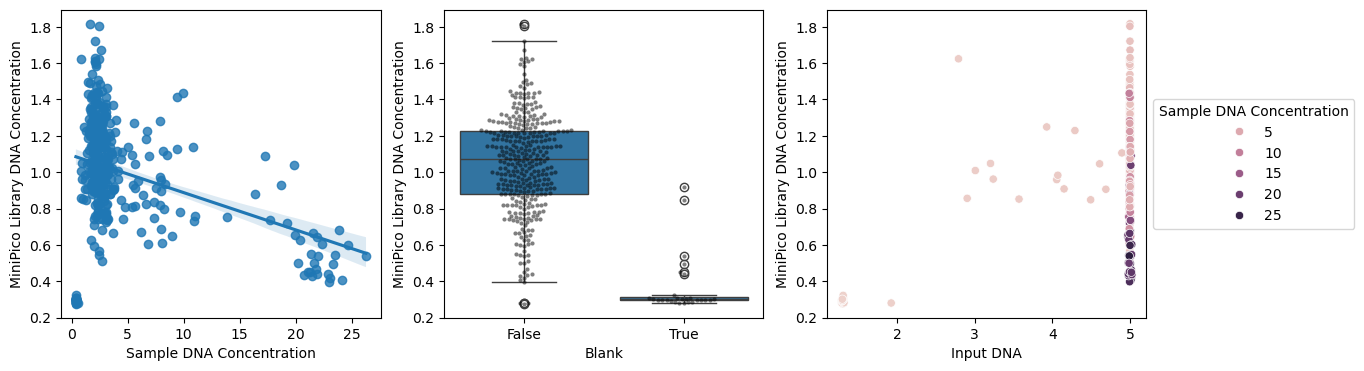

In [48]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
plate_df['Input DNA'] = plate_df['Sample DNA Concentration']*plate_df['Normalized DNA volume']/1000
sns.regplot(x="Sample DNA Concentration", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax1)
sns.boxplot(x="Blank", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax2)
sns.swarmplot(x="Blank", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax2,
              size=3,color='black',alpha=0.5)
sns.scatterplot( x="Input DNA",y="MiniPico Library DNA Concentration",hue='Sample DNA Concentration',data=plate_df ,ax = ax3)
ax3.legend(title='Sample DNA Concentration',loc='center left', bbox_to_anchor=(1, 0.5))

In [49]:
blanks_gdna_concs = plate_df.loc[plate_df['Blank']==True,'Sample DNA Concentration']
samples_gdna_concs = plate_df.loc[plate_df['Blank']==False,'Sample DNA Concentration']
mannwhitneyu(samples_gdna_concs, blanks_gdna_concs)

MannwhitneyuResult(statistic=np.float64(7640.0), pvalue=np.float64(3.956844959686205e-07))

In [50]:
blanks_lib_concs = plate_df.loc[plate_df['Blank']==True,'MiniPico Library Concentration']
samples_lib_concs = plate_df.loc[plate_df['Blank']==False,'MiniPico Library Concentration']
mannwhitneyu(samples_lib_concs, blanks_lib_concs)

MannwhitneyuResult(statistic=np.float64(9348.5), pvalue=np.float64(3.846256694931654e-16))

#### Library concentration heatmap, whole plate

In [51]:
# get concentration and pooling values for plotting
concs = make_2D_array(plate_df, data_col="MiniPico Library Concentration", well_col=well_col).astype(float)
dna = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col=PM_SAMPLE_KEY, well_col=well_col)
i5 = make_2D_array(plate_df, data_col='i5 name', well_col=well_col)
i7 = make_2D_array(plate_df, data_col='i7 name', well_col=well_col)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


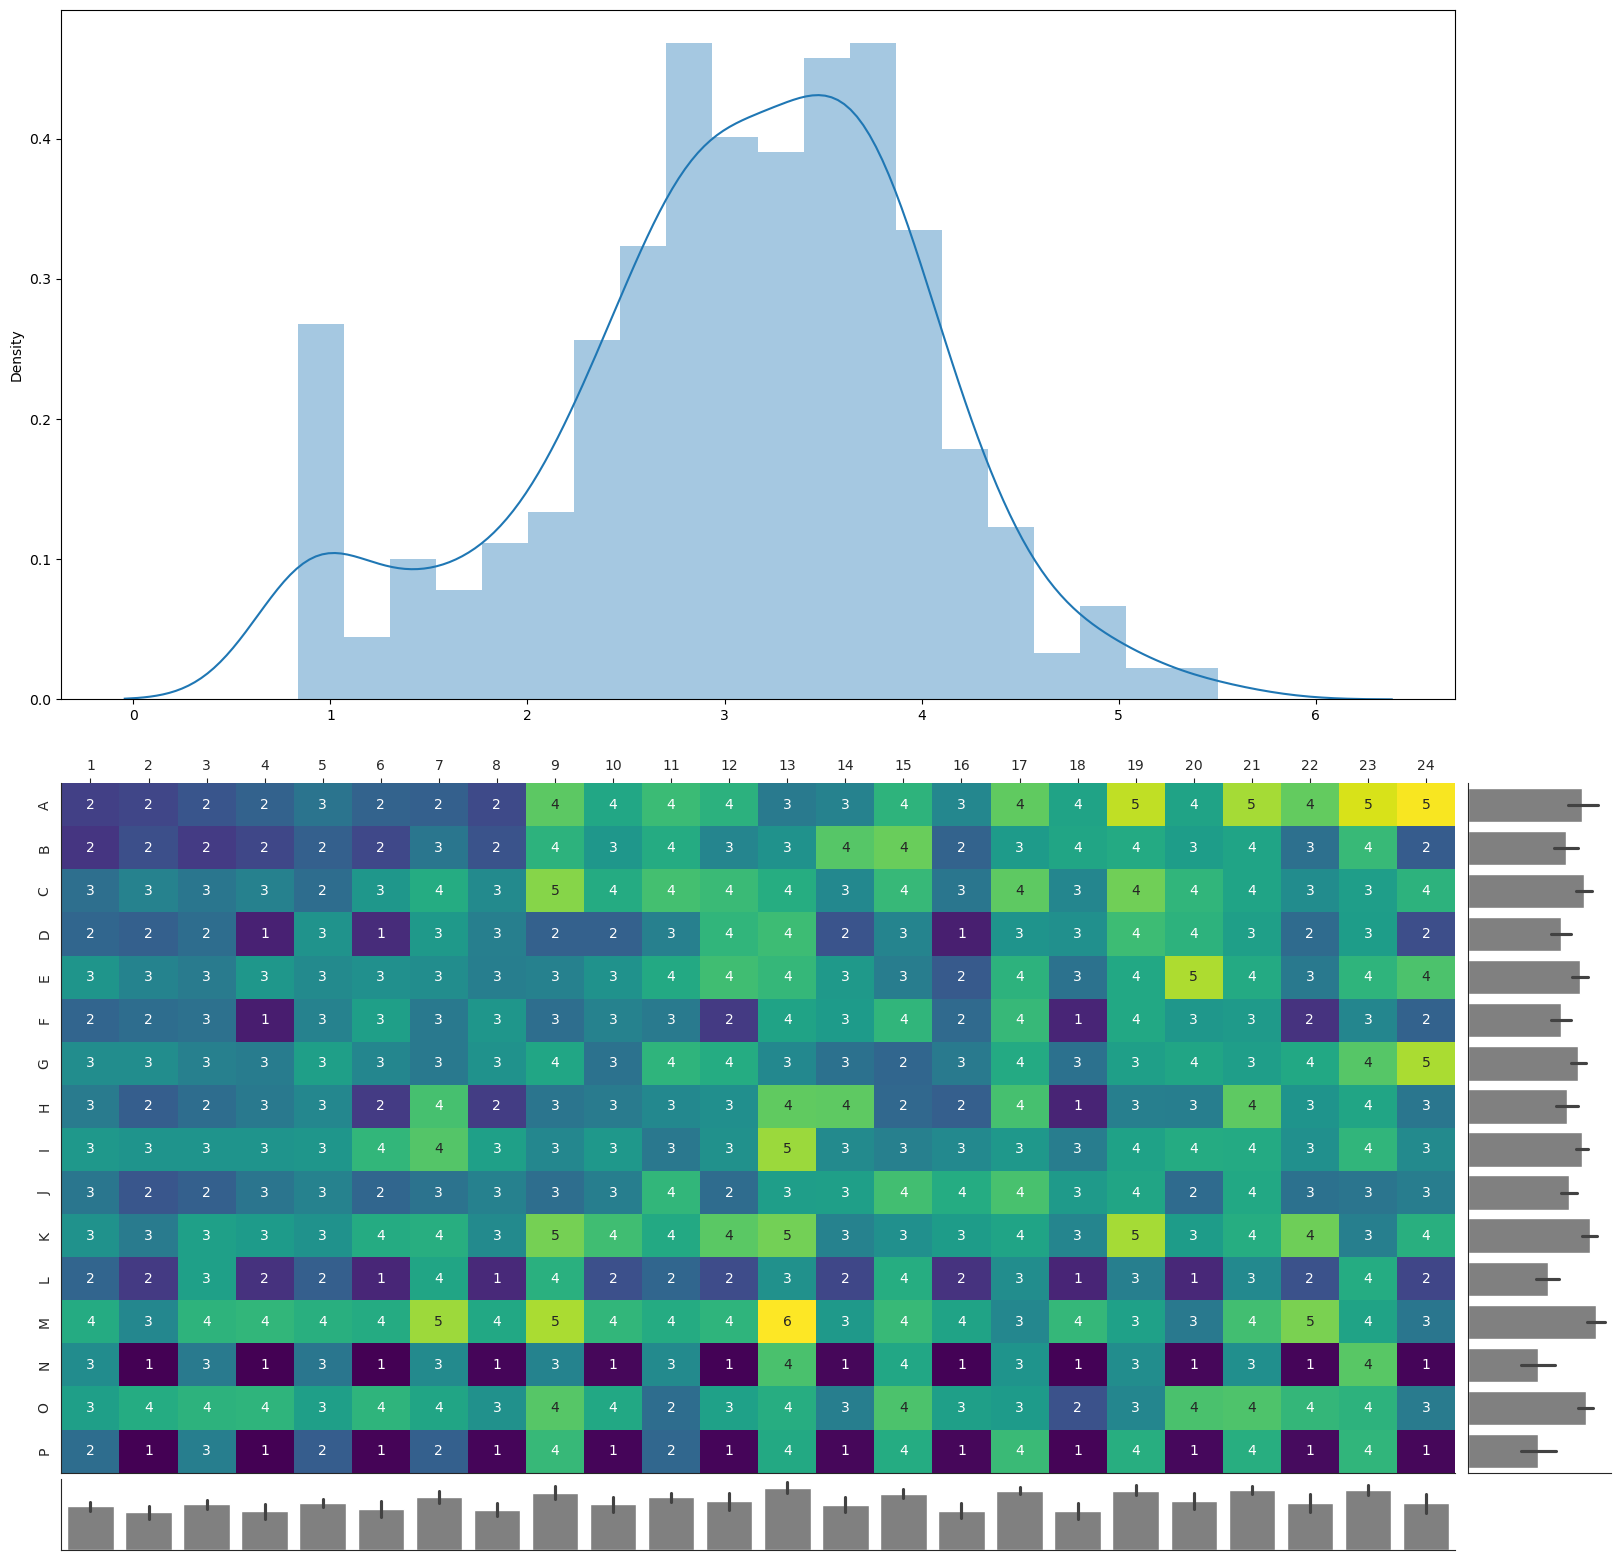

In [52]:
plot_plate_vals(concs, color_map='viridis')

#### Plate maps for individual constituent plates

##### Library concentration heatmap, Plate 1

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


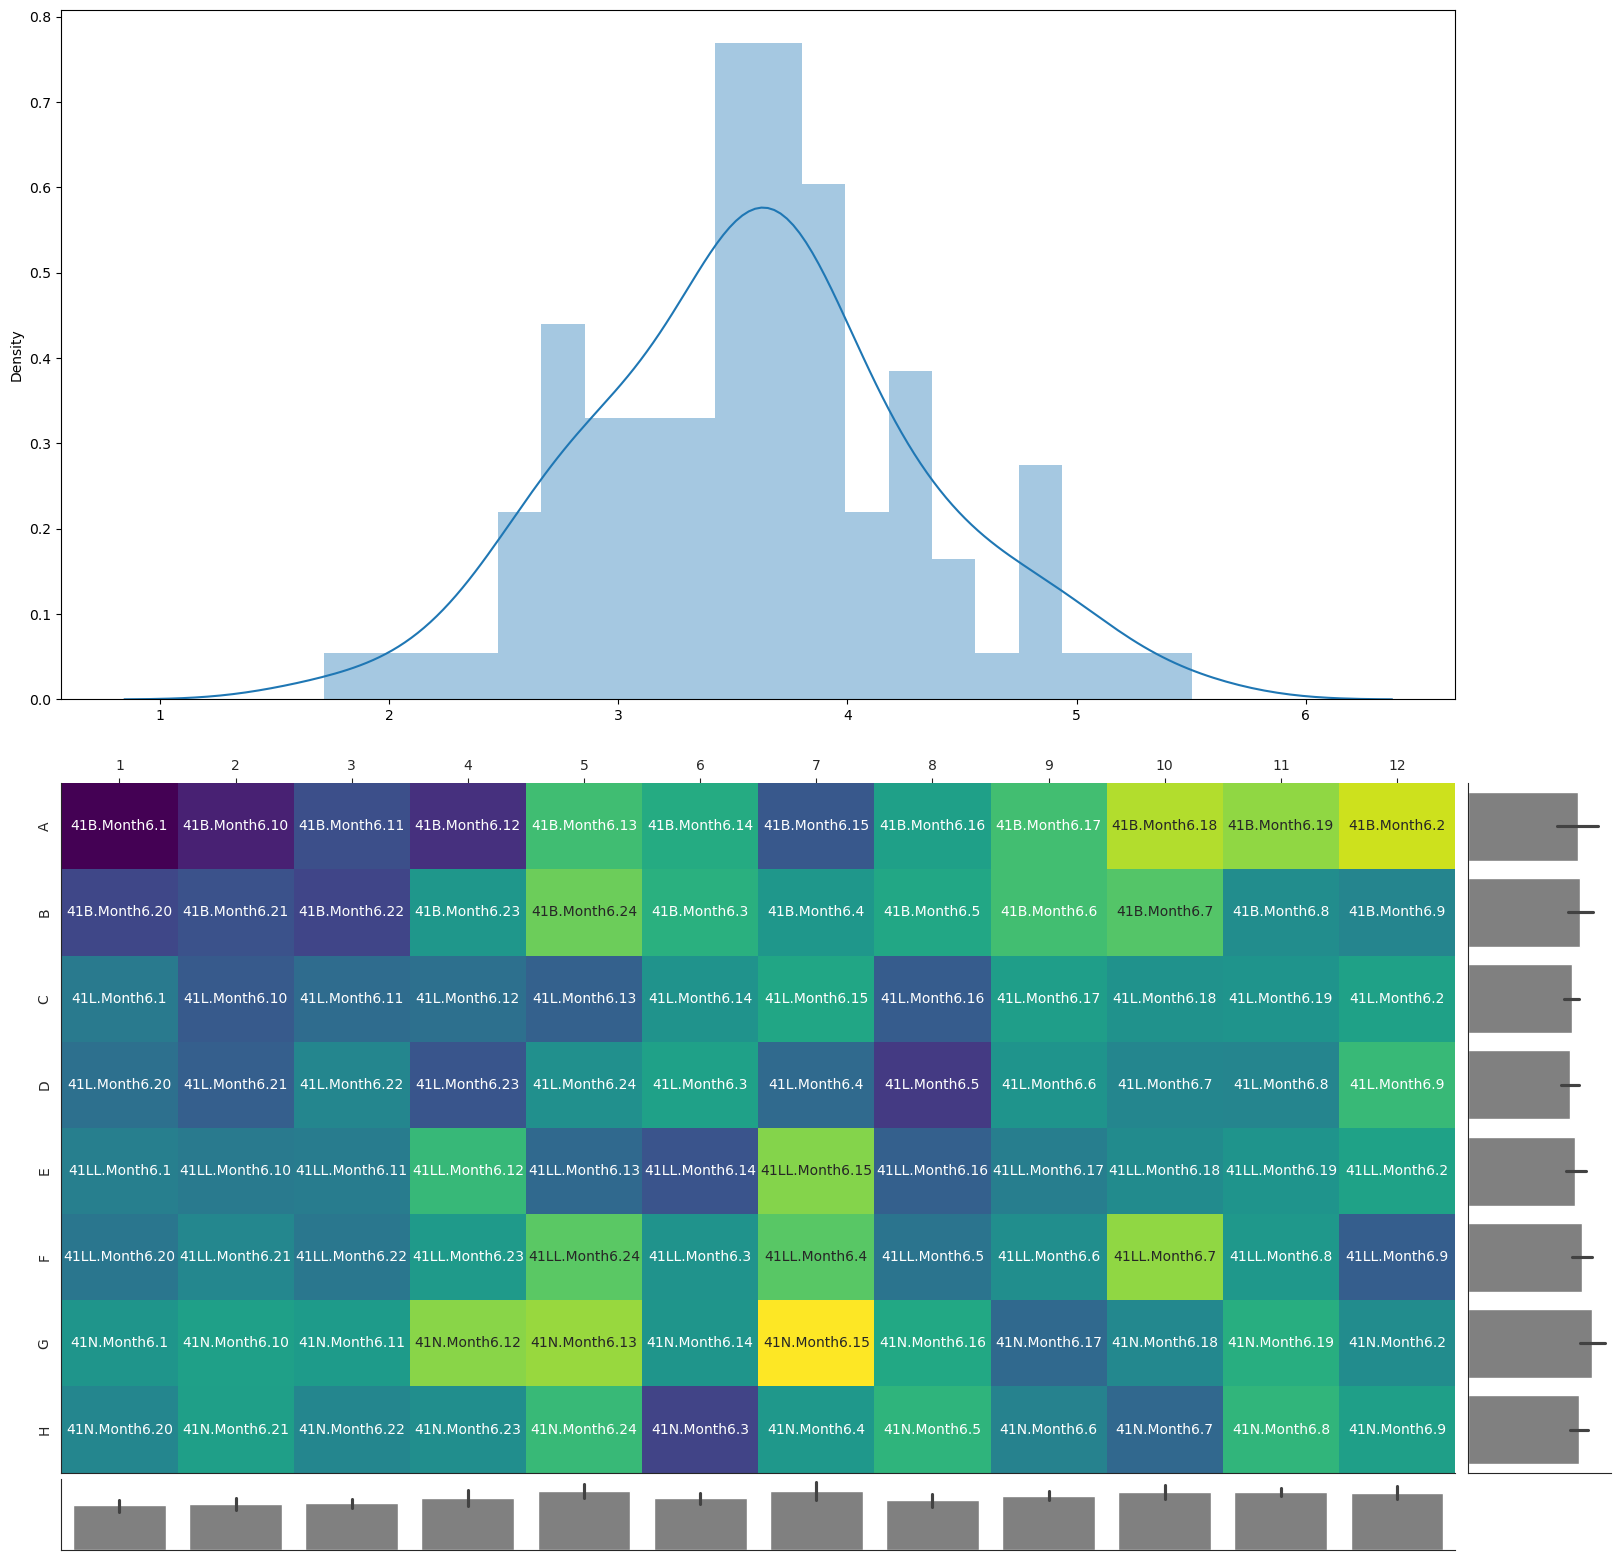

In [53]:
plot_plate_vals(concs[np.ix_(EVEN_ROWS,EVEN_COLS)],
                    annot_str= names[np.ix_(EVEN_ROWS,EVEN_COLS)],
                    color_map='viridis',
                    annot_fmt='')

##### Library concentration heatmap, Plate 2

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


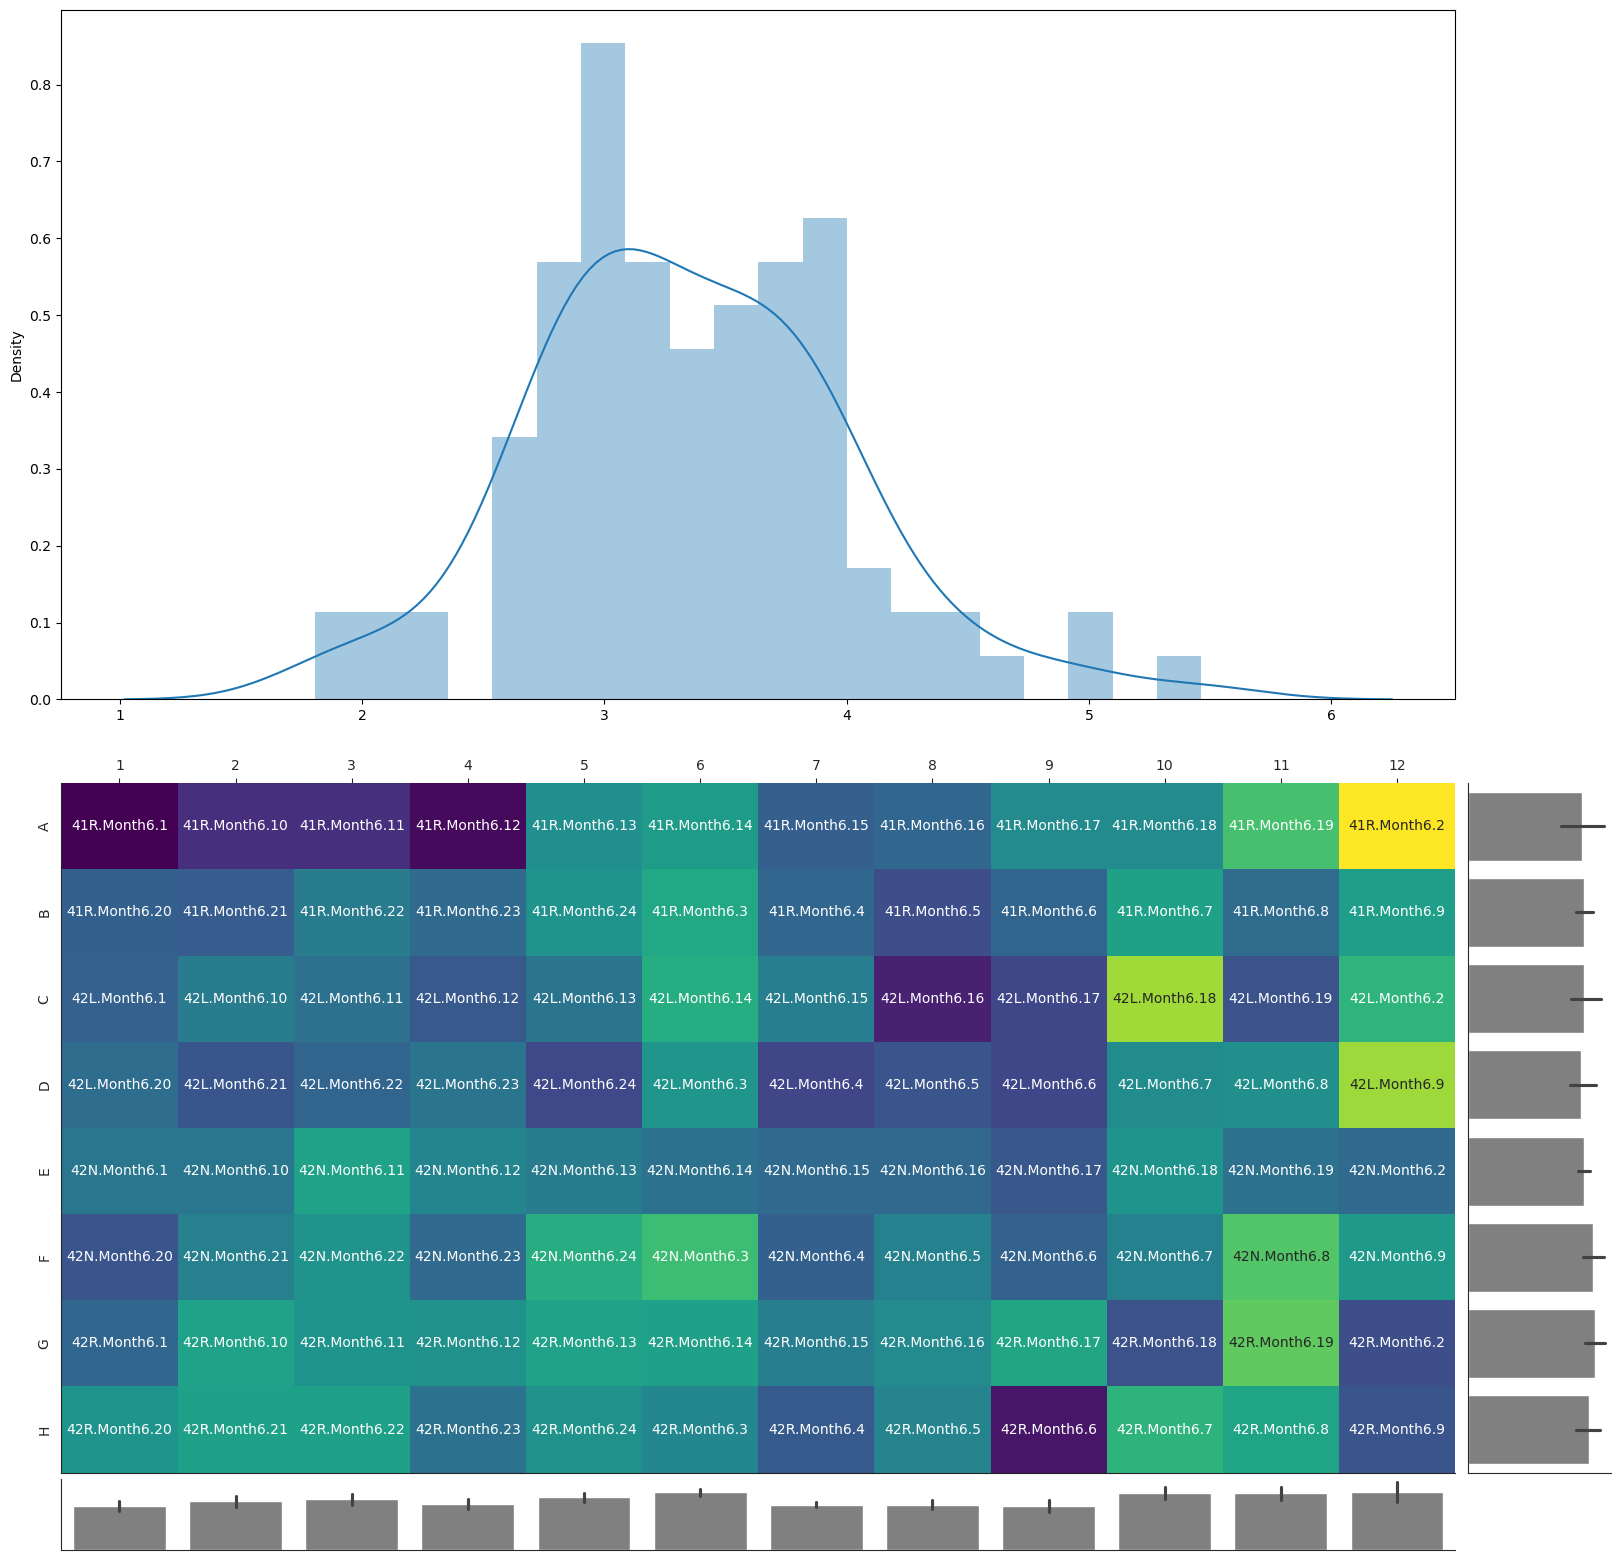

In [54]:
plot_plate_vals(concs[np.ix_(EVEN_ROWS,ODD_COLS)],
                    annot_str= names[np.ix_(EVEN_ROWS,ODD_COLS)],
                    color_map='viridis',
                    annot_fmt='')

##### Library concentration heatmap, Plate 3

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


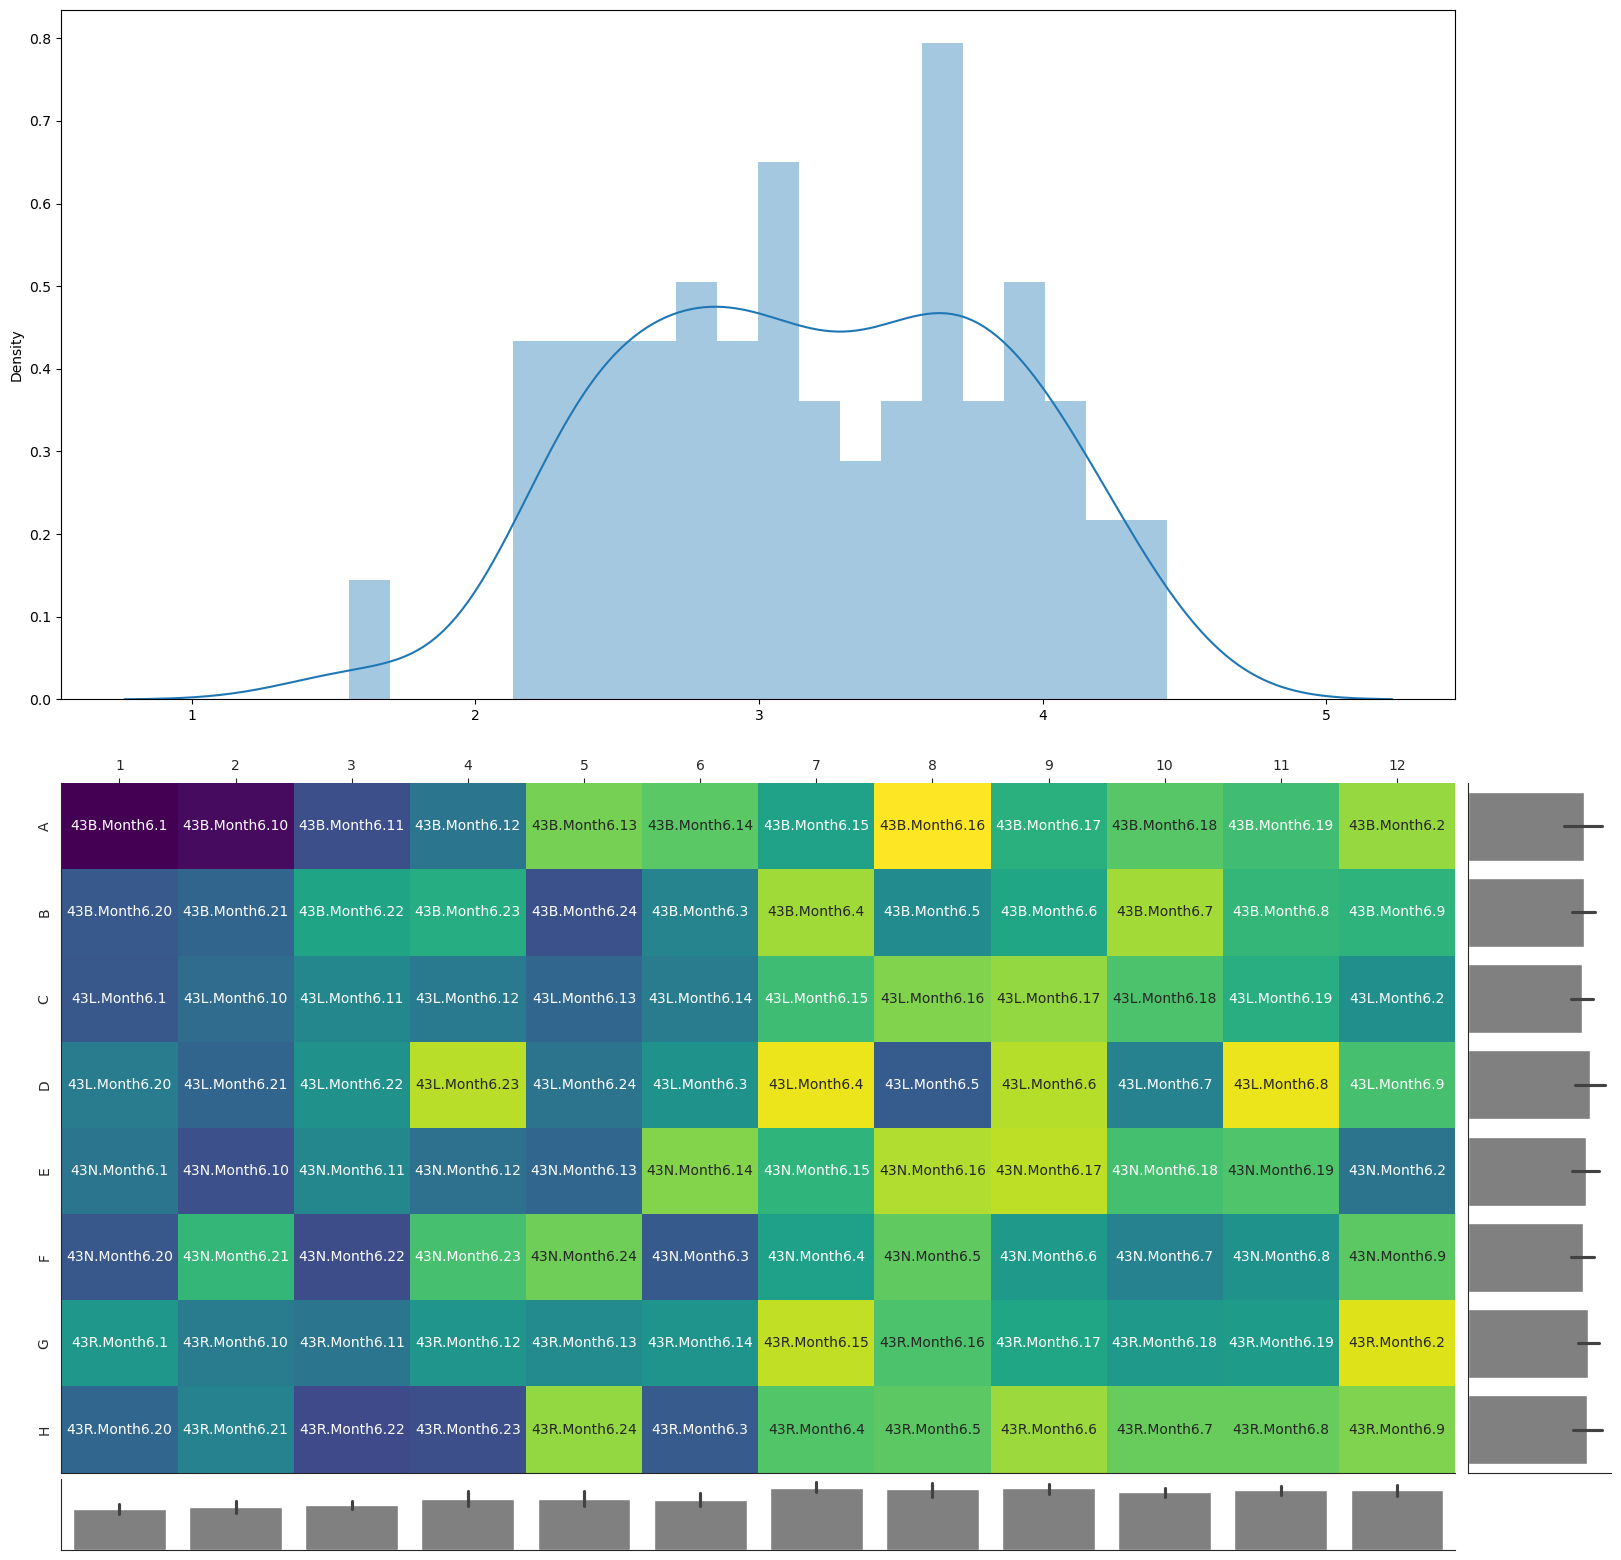

In [55]:
plot_plate_vals(concs[np.ix_(ODD_ROWS,EVEN_COLS)],
                    annot_str= names[np.ix_(ODD_ROWS,EVEN_COLS)],
                    color_map='viridis',
                    annot_fmt='')

##### Library concentration heatmap, Plate 4

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


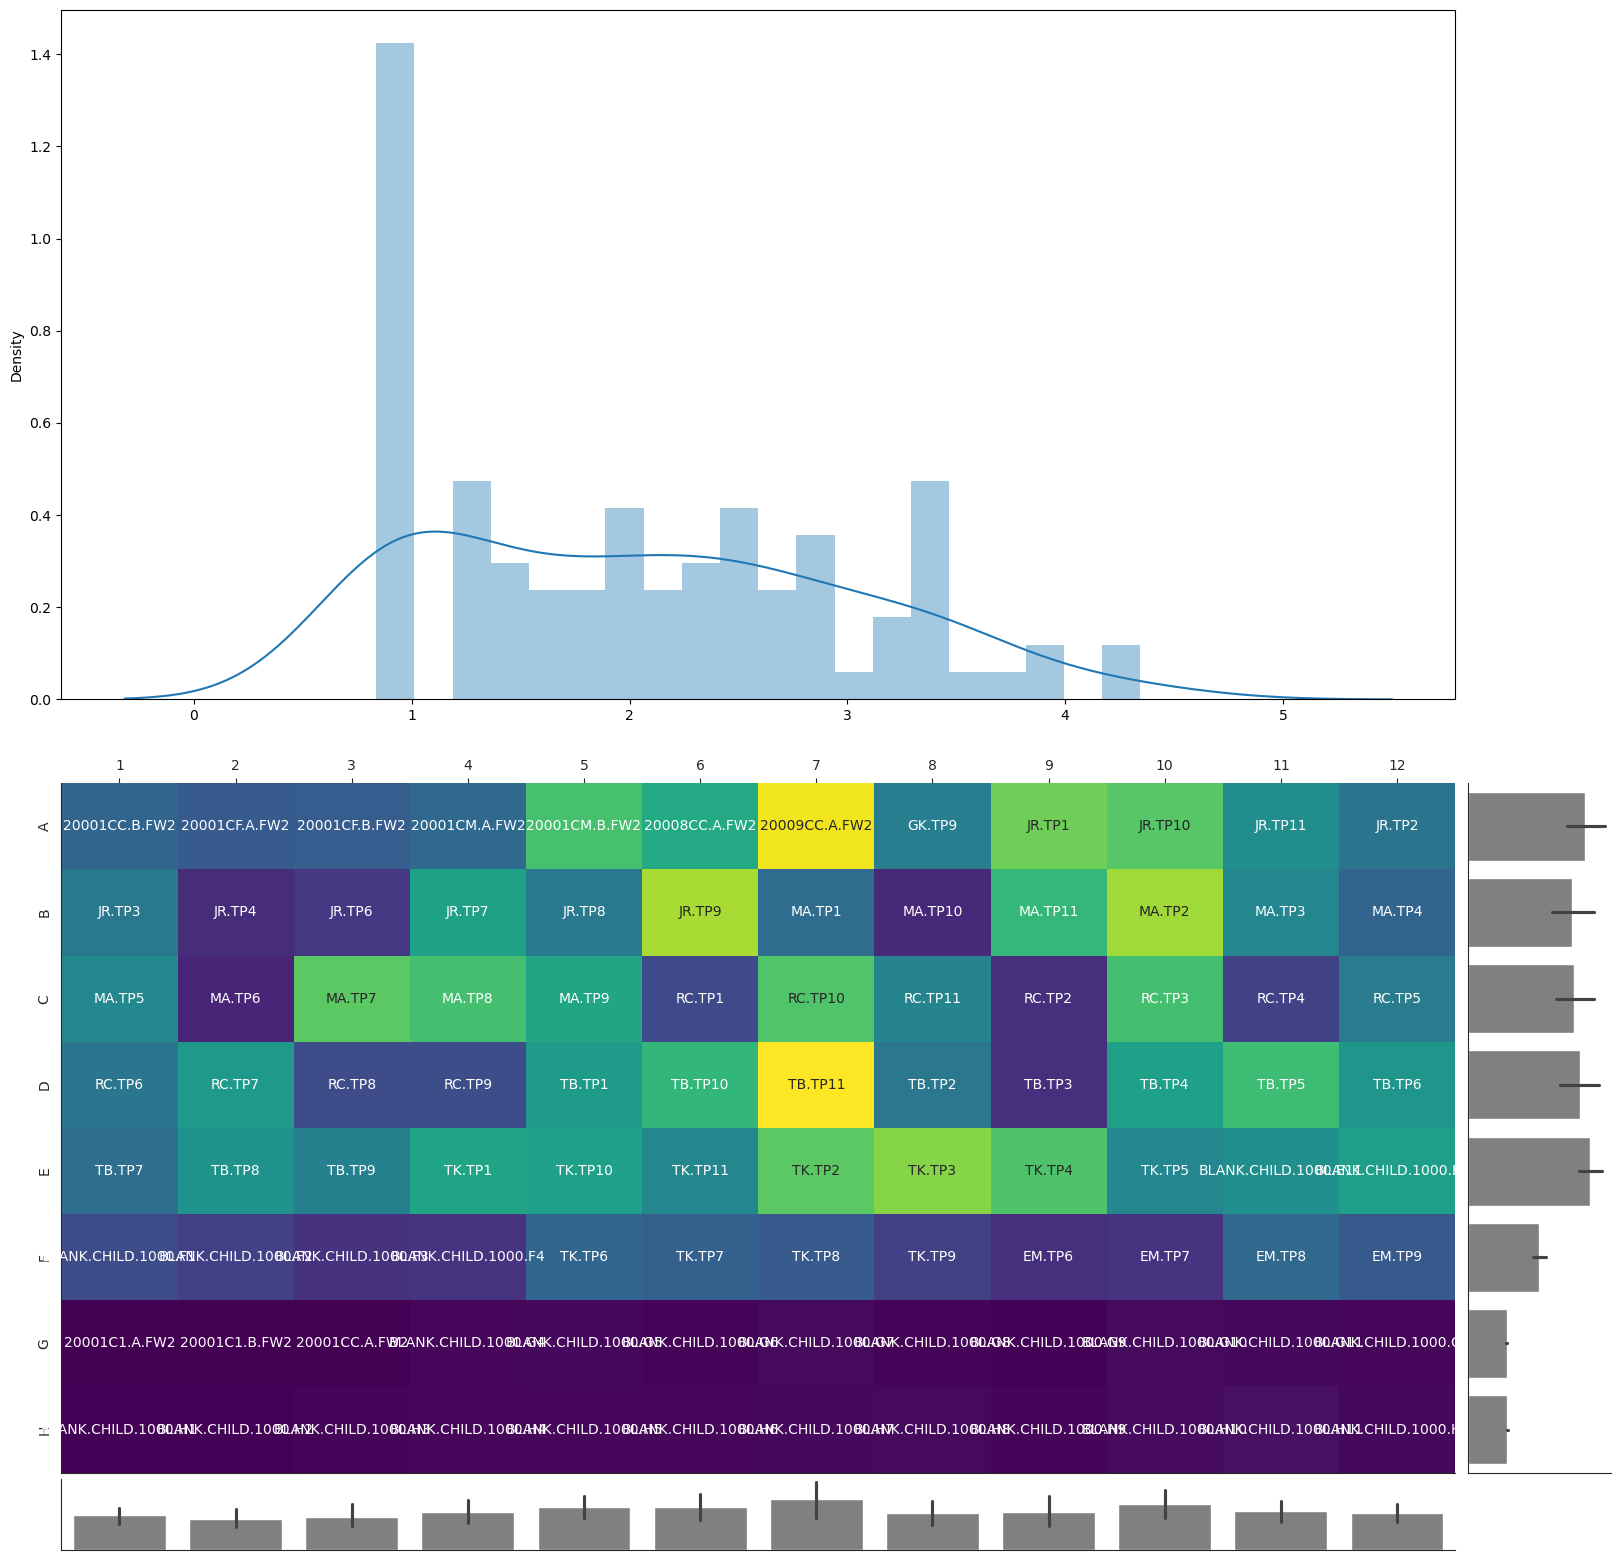

In [56]:
plot_plate_vals(concs[np.ix_(ODD_ROWS,ODD_COLS)],
                    annot_str= names[np.ix_(ODD_ROWS,ODD_COLS)],
                    color_map='viridis',
                    annot_fmt='')

### Part 3 of 4, Step 4 of 7: calculate pooling values for MiniPico with autopool

This step will calculate the sample pooling, and update the sample data frame with the pool info.
There are two automated methods to pool:
1. **norm**: This will attempt to generate a normalized pool, automatically inferring the best parameter for pooling.
    - ***pool_failures***:
        - _high_: will pool failures at the highest pooling volume from optimized pooling.
        - _low_: will pool failures at the lowest pooling volume from optimized pooling.

2. **evp**: This will pool an even volume per sample.
    - ***total_vol***: (Optional, Default: 100µL) The total volume to pool, in uL. Each sample will be pooled at 1/N of that volume, where N is total number of samples in the prep.

3. **automate**: (Optional, Default = True) When False, this argument will allow one input parameters for **Legacy** arguments. 

> **Legacy**
> There are legacy parameters to control pooling behaviors when autopool automation (automate=True) returns a poor result. To use these parameters, one must pass automate=False.

>   - **min_conc**: (default: 0) This is the minimum concentration for a sample to be considered for pooling.
    Set to 0 to pool all samples, regardless of concentration. Increasing this will have the 
    effect of increasing pool concentration, at the expense of samples dropping out. 
>   - **floor_conc**: This is the lowest concentration equivalent for which a sample will be 
    accurately pooled. Samples below this concentration will be pooled to the volume that they 
    would have been if they were actually that concentration. For example, if `floor_conc=20`, 
    and a sample at 20 nM pools at 500 nL, a sample at 40 nM will pool at 250 nL but a sample at 
    10 nM will still pool at 500 nL (rather than 1000). Increasing this value will have the effect 
    of increasing pool concentration, but decreasing read counts for low-concentration samples. 
>   - **total_nmol**: This is the total number of molecules to shoot for in the pool. Increasing
    this will increase the overall volume of the pool.


#### Calculate and plot pooling volumes

Floor concentration: 1.2030303030303031
Pool concentration: 3.04
Pool volume: 190000.00


/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


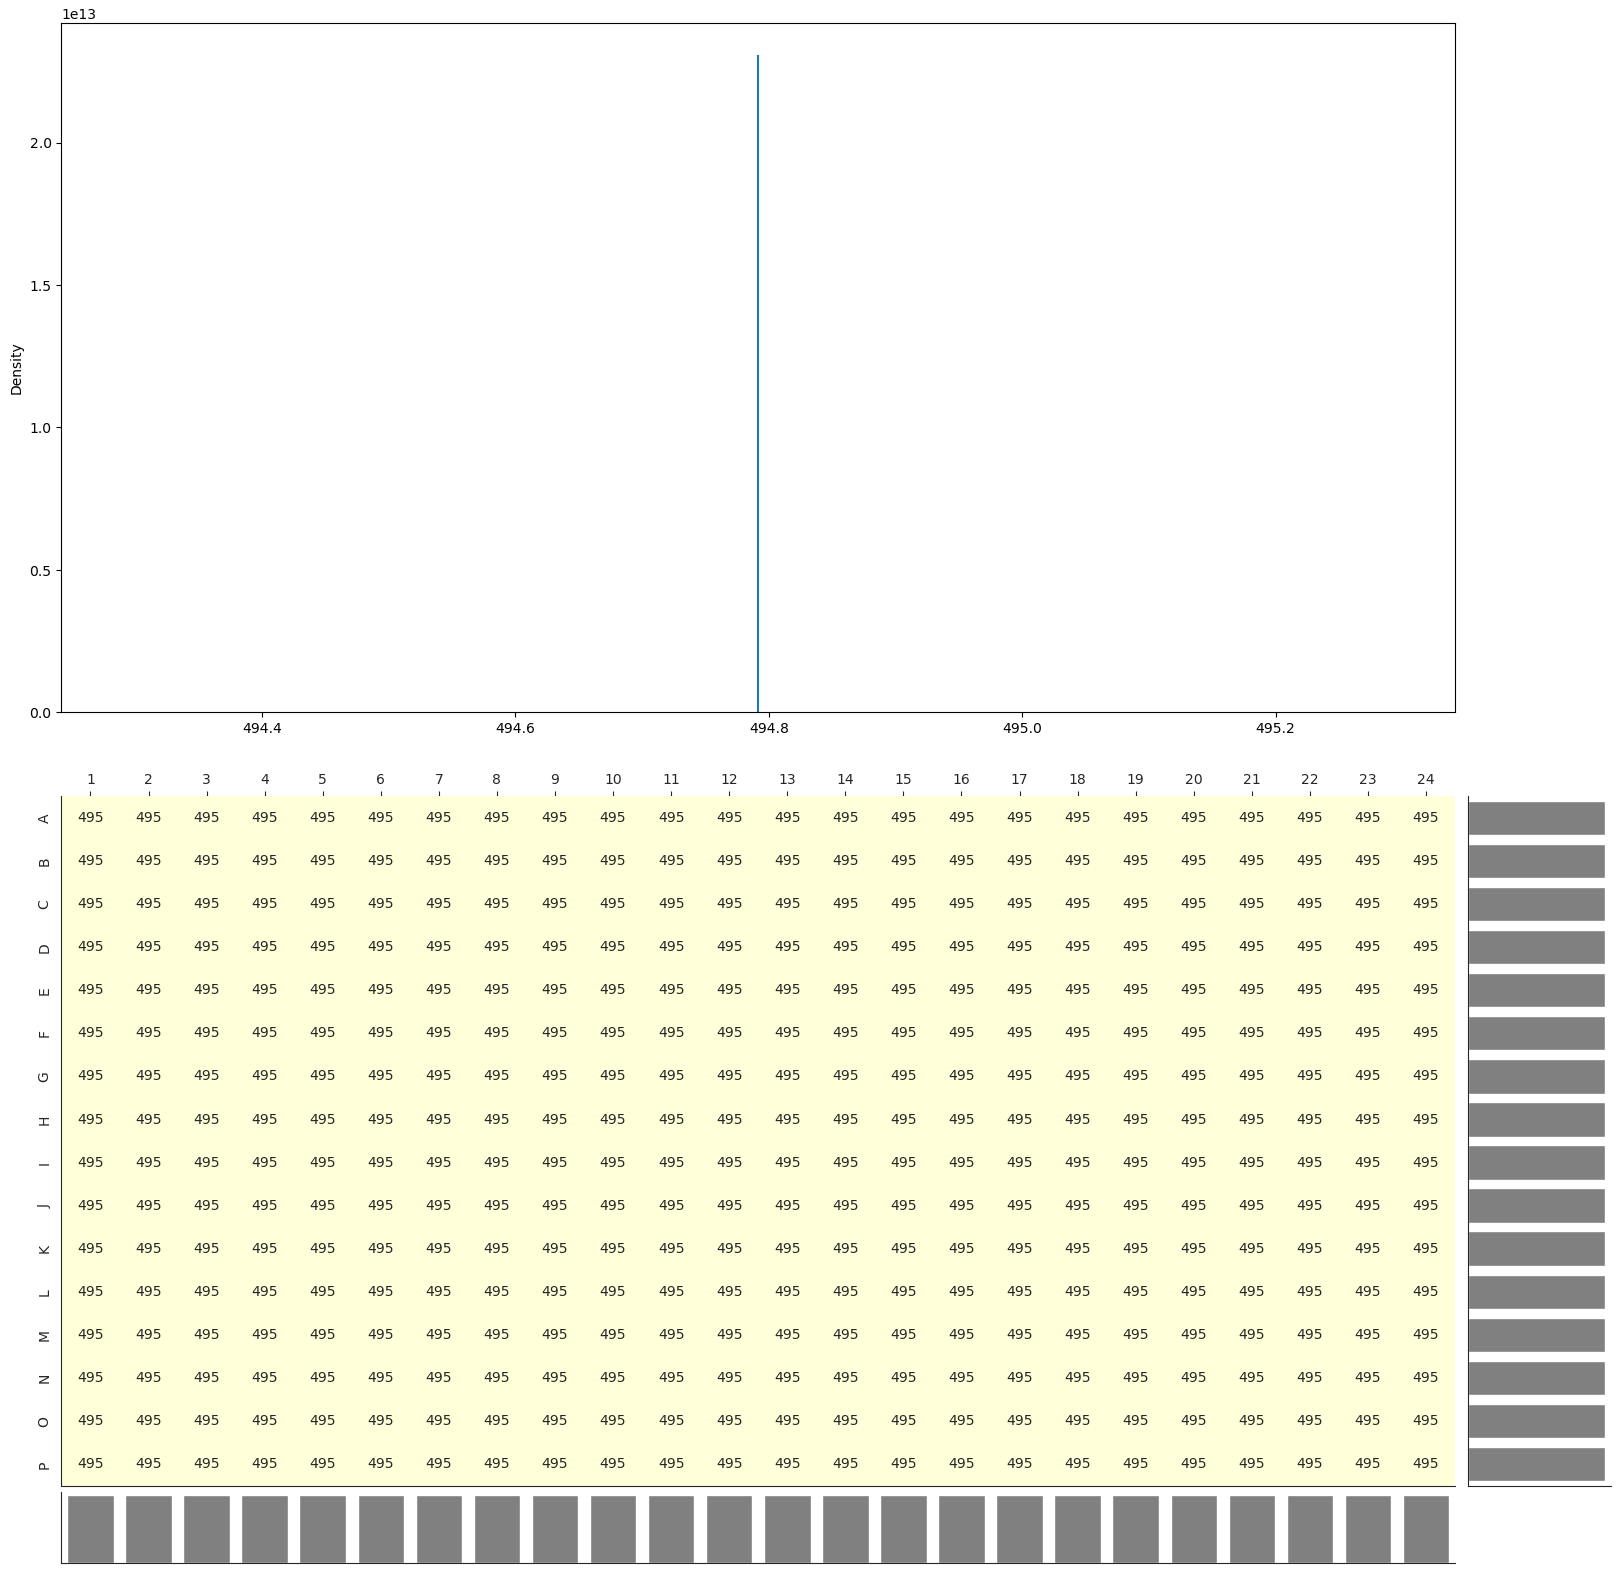

In [57]:
threshold = find_threshold(plate_df['MiniPico Library Concentration'], plate_df['Blank'])
plate_df = autopool(plate_df,method='evp',total_vol=190)

# visualize
print("Floor concentration: {}".format(threshold))
vols = make_2D_array(plate_df, data_col='MiniPico Pooled Volume', well_col=well_col).astype(float)
conc, vol = estimate_pool_conc_vol(plate_df['MiniPico Pooled Volume'], plate_df['MiniPico Library Concentration'])
print("Pool concentration: {:.2f}".format(conc))
print("Pool volume: {:.2f}".format(vol))
with suppress(np.linalg.LinAlgError):
    plot_plate_vals(vols)

<Axes: xlabel='MiniPico Library Concentration', ylabel='MiniPico Pooled Volume'>

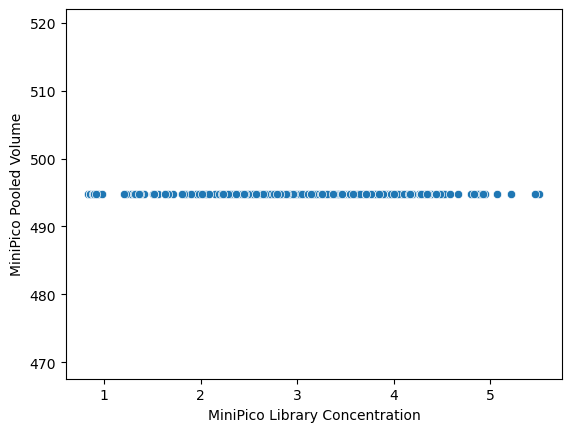

In [58]:
vols = make_2D_array(plate_df, data_col='MiniPico Pooled Volume', well_col=well_col).astype(float)
sns.scatterplot(x='MiniPico Library Concentration', y='MiniPico Pooled Volume',data=plate_df)

### Part 3 of 4, Step 5 of 7: make equal volume pooling pick list and write to a file

In [59]:
evp_picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)

In [60]:
# Write the picklist as .csv
evp_picklist_fp = './test_output/Pooling/YYYY_MM_DD_Celeste_Adaptation_evp.csv'

if os.path.isfile(evp_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [61]:
with open(evp_picklist_fp,'w') as f:
    f.write(evp_picklist)

!head {evp_picklist_fp}

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2,A1,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A2,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A3,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A4,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A5,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A6,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A7,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A8,,494.79,NormalizedDNA,A1
1,384LDV_AQ_B2,A9,,494.79,NormalizedDNA,A1


### Part 3 of 4, Step 6 of 7: Write plate dataframe to file

We want to keep all that useful information together in one place so that
it can be easily parsed later. 

In [62]:
# Write the sample info DataFrame as .txt
plate_df_fp = './test_output/QC/YYYY_MM_DD_Celeste_Adaptation_matrix_df.txt'

if os.path.isfile(plate_df_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [63]:
plate_df.to_csv(plate_df_fp, sep='\t')

### Part 3 of 4, Step 7 of 7: Make sample sheets and write to files

This step takes the pooled sample information and writes Illumina sample 
sheets that can be given directly to the sequencing center.

`# TODO: is this true? I thought Sample Name was NOT bcl2fastq-compatible?`

bcl2fastq-compatible names will be in the **`Sample ID`** and **`Sample Name`** columns. The
original sample names will be in the **`Description`** column.

Modify **`lanes`** to indicate which lanes this pool will be sequenced on.

**Project Name** and **Project Plate** values will be placed in the 
**`Sample_Project`** and **`Sample_Name`** columns, respectively.

In [64]:
# Determine the sample sheet type to make
expt_type = ABSQUANT_SHEET_TYPE if is_absquant(plate_df) \
    else STANDARD_METAG_SHEET_TYPE
expt_type

'standard_metag'

`bcl2fastq` requires *only* alphanumeric, hyphens, and underscore characters. 
We'll replace all non-those characters with underscores and add the 
bcl2fastq-compatible names to the DataFrame.

In [65]:
# Set bcl2fastq-compatible sample ids
plate_df['sample sheet Sample_ID'] = \
    plate_df[PM_SAMPLE_KEY].map(bcl_scrub_name)
plate_df

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,MiniPico Library DNA Concentration,MiniPico Library Concentration,Input DNA,MiniPico Pooled Volume,sample sheet Sample_ID
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,iTru5_plate,iTru7_112_12,ACGATGAC,G24,iTru7_plate,0.566,1.715152,4.999620,494.791667,41B_Month6_1
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,iTru5_plate,iTru7_113_01,CGTTATGC,I2,iTru7_plate,0.680,2.060606,4.998212,494.791667,41B_Month6_10
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,iTru5_plate,iTru7_113_02,GATACTGG,I4,iTru7_plate,0.868,2.630303,4.997430,494.791667,41B_Month6_11
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,iTru5_plate,iTru7_113_03,CTACTTGG,I6,iTru7_plate,0.740,2.242424,5.002463,494.791667,41B_Month6_12
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,iTru5_plate,iTru7_113_04,CATACCAC,I8,iTru7_plate,1.431,4.336364,5.001152,494.791667,41B_Month6_13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,BLANK.CHILD.1000.H8,8,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,H,...,iTru5_plate,iTru7_112_07,CAGTGAAG,G14,iTru7_plate,0.306,0.927273,1.298500,494.791667,BLANK_CHILD_1000_H8
380,BLANK.CHILD.1000.H9,9,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,H,...,iTru5_plate,iTru7_112_08,CCTACTGA,G16,iTru7_plate,0.294,0.890909,1.291500,494.791667,BLANK_CHILD_1000_H9
381,BLANK.CHILD.1000.H10,10,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,H,...,iTru5_plate,iTru7_112_09,TGTGAAGC,G18,iTru7_plate,0.308,0.933333,1.302000,494.791667,BLANK_CHILD_1000_H10
382,BLANK.CHILD.1000.H11,11,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,H,...,iTru5_plate,iTru7_112_10,GTCTGATC,G20,iTru7_plate,0.322,0.975758,1.302000,494.791667,BLANK_CHILD_1000_H11


In [66]:
# Store the final pre-sample-sheet version of the plate dataframe
plate_df_fp = './test_output/QC/YYYY_MM_DD_Celeste_Adaptation_matrix_df_complete.txt'
plate_df.to_csv(plate_df_fp, sep='\t')

In [67]:
# Extend the metadata dictionary with additional information
metadata_dict_w_sample_context = make_sections_dict(
    plate_df, studies_info, expt_name,
    expt_type, SHEET_TYPE_VERSIONS[expt_type], BIOINFO_BASE)
metadata_dict_w_sample_context

{'Experiment Name': 'RKL4982',
 'SheetType': 'standard_metag',
 'SheetVersion': '101',
 'Assay': 'Metagenomic',
 'Bioinformatics': [{'ForwardAdapter': 'GATCGGAAGAGCACACGTCTGAACTCCAGTCAC',
   'ReverseAdapter': 'GATCGGAAGAGCGTCGTGTAGGGAAAGGAGTGT',
   'library_construction_protocol': 'Knight Lab Kapa HyperPlus',
   'BarcodesAreRC': 'True',
   'Sample_Project': 'Celeste_Adaptation_12986',
   'QiitaID': '12986',
   'HumanFiltering': 'False',
   'experiment_design_description': 'isolate sequencing',
   'contains_replicates': np.False_},
  {'ForwardAdapter': 'GATCGGAAGAGCACACGTCTGAACTCCAGTCAC',
   'ReverseAdapter': 'GATCGGAAGAGCGTCGTGTAGGGAAAGGAGTGT',
   'library_construction_protocol': 'Knight Lab Kapa HyperPlus',
   'BarcodesAreRC': 'True',
   'Sample_Project': 'CHILD_15510',
   'QiitaID': '15510',
   'HumanFiltering': 'True',
   'experiment_design_description': 'whole genome sequencing',
   'contains_replicates': np.False_},
  {'ForwardAdapter': 'GATCGGAAGAGCACACGTCTGAACTCCAGTCAC',
   'Rev

**`sequencer`** is important for making sure the i5 index is in the correct 
orientation for demultiplexing. `NovaSeq6000`, `HiSeq4000`, `HiSeq3000`, 
`NextSeq`, `MiniSeq`, and `iSeq` all require reverse-complemented i5 
index sequences. If you enter one of these exact strings in for `sequencer`, 
it will revcomp the i5 sequence for you.

`HiSeq2500`, `MiSeq`, `NovaSeqX`, and `NovaSeqXPlus` will NOT revcomp the 
i5 sequence. 

#### Make and save the iSeq sample sheet

In [68]:
lanes = [1]
iseq_sheet = make_sample_sheet(metadata_dict_w_sample_context, 
                               plate_df, 'iSeq', lanes)

iSeq: i5 barcodes are output as reverse complements


In [69]:
# Write the iseq samplesheet as .csv
iseq_sample_sheet_fp = './test_output/SampleSheets/YYYY_MM_DD_Celeste_Adaptation_12986_16_17_18_21_matrix_samplesheet_iseq.csv'

if os.path.isfile(iseq_sample_sheet_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [70]:
with open(iseq_sample_sheet_fp,'w') as f:
    iseq_sheet.write(f)
    
!head -n 30 {iseq_sample_sheet_fp}
!echo ...
!tail -n 15 {iseq_sample_sheet_fp}

[Header],,,,,,,,,,
IEMFileVersion,4,,,,,,,,,
SheetType,standard_metag,,,,,,,,,
SheetVersion,101,,,,,,,,,
Investigator Name,Knight,,,,,,,,,
Experiment Name,RKL4982,,,,,,,,,
Date,2024-08-28,,,,,,,,,
Workflow,GenerateFASTQ,,,,,,,,,
Application,FASTQ Only,,,,,,,,,
Assay,Metagenomic,,,,,,,,,
Description,,,,,,,,,,
Chemistry,Default,,,,,,,,,
,,,,,,,,,,
[Reads],,,,,,,,,,
151,,,,,,,,,,
151,,,,,,,,,,
,,,,,,,,,,
[Settings],,,,,,,,,,
ReverseComplement,0,,,,,,,,,
,,,,,,,,,,
[Data],,,,,,,,,,
Sample_ID,Sample_Name,Sample_Plate,well_id_384,I7_Index_ID,index,I5_Index_ID,index2,Sample_Project,Well_description,Lane
41B_Month6_1,41B.Month6.1,Celeste_Adaptation_12986_Plate_16,A1,iTru7_112_12,ACGATGAC,iTru5_01_A,TTGTCGGT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16.41B.Month6.1.A1,1
41B_Month6_10,41B.Month6.10,Celeste_Adaptation_12986_Plate_16,A3,iTru7_113_01,CGTTATGC,iTru5_02_A,TTGCGAAG,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16.41B.Month6.10.A3,1
41B_Month6_11,41B.Month6.11,C

#### Make and save NovaSeq6000 sample sheet

In [71]:
lanes = [1]
novaseq_sheet = make_sample_sheet(metadata_dict_w_sample_context, 
                                  plate_df, 'NovaSeq6000', lanes)

NovaSeq6000: i5 barcodes are output as reverse complements


In [72]:
# Write the novaseq samplesheet as .csv
novaseq_sample_sheet_fp = './test_output/SampleSheets/YYYY_MM_DD_Celeste_Adaptation_12986_16_17_18_21_matrix_samplesheet_novaseq.csv'

if os.path.isfile(novaseq_sample_sheet_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [73]:
with open(novaseq_sample_sheet_fp,'w') as f:
    novaseq_sheet.write(f)
    
!head -n 30 {novaseq_sample_sheet_fp}
!echo ...
!tail -n 15 {novaseq_sample_sheet_fp}

[Header],,,,,,,,,,
IEMFileVersion,4,,,,,,,,,
SheetType,standard_metag,,,,,,,,,
SheetVersion,101,,,,,,,,,
Investigator Name,Knight,,,,,,,,,
Experiment Name,RKL4982,,,,,,,,,
Date,2024-08-28,,,,,,,,,
Workflow,GenerateFASTQ,,,,,,,,,
Application,FASTQ Only,,,,,,,,,
Assay,Metagenomic,,,,,,,,,
Description,,,,,,,,,,
Chemistry,Default,,,,,,,,,
,,,,,,,,,,
[Reads],,,,,,,,,,
151,,,,,,,,,,
151,,,,,,,,,,
,,,,,,,,,,
[Settings],,,,,,,,,,
ReverseComplement,0,,,,,,,,,
MaskShortReads,1,,,,,,,,,
OverrideCycles,Y151;I8N2;I8N2;Y151,,,,,,,,,
,,,,,,,,,,
[Data],,,,,,,,,,
Sample_ID,Sample_Name,Sample_Plate,well_id_384,I7_Index_ID,index,I5_Index_ID,index2,Sample_Project,Well_description,Lane
41B_Month6_1,41B.Month6.1,Celeste_Adaptation_12986_Plate_16,A1,iTru7_112_12,ACGATGAC,iTru5_01_A,TTGTCGGT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16.41B.Month6.1.A1,1
41B_Month6_10,41B.Month6.10,Celeste_Adaptation_12986_Plate_16,A3,iTru7_113_01,CGTTATGC,iTru5_02_A,TTGCGAAG,Celeste_Adaptation_12986,Celeste_Adap

## Part 4 (of 4): Workflow for Read Distribution Summary and Pool Normalization

#### Part 4 of 4, Step 1 of 4: import and merge per_sample read distributions

Import tsv file(s) with read_counts from per_sample_fastq files and merge with growing plate_df


In [74]:
# Enter paths to read counts file(s)
read_counts_fps = [
    './test_data/Demux/YYYY_MM_DD_Celeste_Adaptation_raw_counts.tsv',
    './test_data/Demux/YYYY_MM_DD_Celeste_Marmoset_raw_counts.tsv',
    './test_data/Demux/YYYY_MM_DD_Child_raw_counts.tsv',
]

In [75]:
# Import reads counts from file to dataframes
CATEGORY_KEY = 'Category'
UNIQUE_READS_KEY = 'Unique Reads'
DUPLICATE_READS_KEY = 'Duplicate Reads'
read_counts_df = join_dfs_from_files(
    read_counts_fps, [CATEGORY_KEY, UNIQUE_READS_KEY, DUPLICATE_READS_KEY],
    unique_cols=[CATEGORY_KEY], 
    dtype={CATEGORY_KEY: str, UNIQUE_READS_KEY: int, DUPLICATE_READS_KEY: int})
    
trimmed_reads_mask = read_counts_df[CATEGORY_KEY].str.contains('trimmed')
raw_read_counts_df = read_counts_df.loc[~trimmed_reads_mask].copy()
filtered_read_counts_df = read_counts_df.loc[trimmed_reads_mask].copy()

##Can also import counts from Qiita per_sample_FASTQ summaries.  
# per_sample_fastq_counts_df = pd.read_csv('./test_data/Demux/YYYY_MM_DD_Celeste_Adaptation_16_17_18_21_per_sample_fastq.tsv',
#                                          sep='\t')

In [76]:
# Merge read_counts_df with plate_df 
plate_df_w_reads = merge_read_counts(
    plate_df, raw_read_counts_df, 
    reads_column_name='Raw Reads')
plate_df_w_reads = merge_read_counts(
    plate_df_w_reads, filtered_read_counts_df, 
    reads_column_name='Filtered Reads')

# plate_df_w_reads = merge_read_counts(
#    plate_df_w_reads, per_sample_fastq_counts_fp,
#    reads_column_name='Qiita Reads')

plate_df_w_reads.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,i7 sequence,i7 well,i7 plate,MiniPico Library DNA Concentration,MiniPico Library Concentration,Input DNA,MiniPico Pooled Volume,sample sheet Sample_ID,Raw Reads,Filtered Reads
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,ACGATGAC,G24,iTru7_plate,0.566,1.715152,4.999620,494.791667,41B_Month6_1,8636.0,3266.0
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,CGTTATGC,I2,iTru7_plate,0.680,2.060606,4.998212,494.791667,41B_Month6_10,11672.0,6078.0
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,GATACTGG,I4,iTru7_plate,0.868,2.630303,4.997430,494.791667,41B_Month6_11,19010.0,9674.0
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,CTACTTGG,I6,iTru7_plate,0.740,2.242424,5.002463,494.791667,41B_Month6_12,23956.0,12522.0
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,CATACCAC,I8,iTru7_plate,1.431,4.336364,5.001152,494.791667,41B_Month6_13,16594.0,8504.0


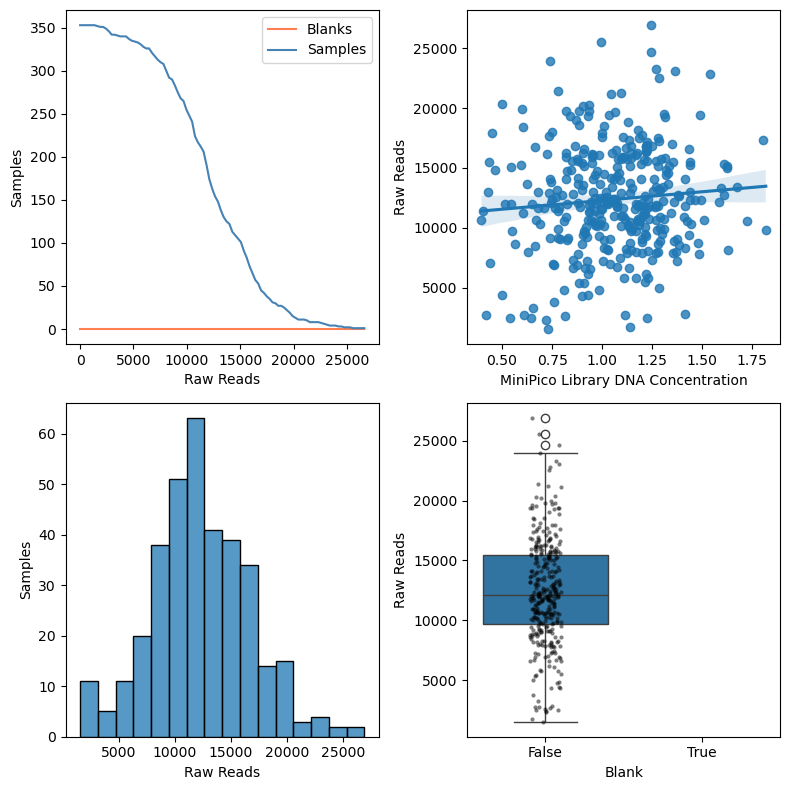

In [77]:
reads_column = 'Raw Reads'

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# evenness plot
rmax = int(round(plate_df_w_reads[reads_column].max(),-2))
survival_df = pd.concat([read_survival(plate_df_w_reads.loc[plate_df_w_reads['Blank'] == True,
                                                            reads_column], label='Blanks',rmax=rmax),
                         read_survival(plate_df_w_reads.loc[plate_df_w_reads['Blank'] == False,
                                                            reads_column], label='Samples',rmax=rmax)])

ax3.set_xlabel(reads_column)
ax3.set_ylabel('Samples')
survival_df.plot(color = ['coral','steelblue'],ax=ax1)
ax1.set_xlabel(reads_column)
ax1.set_ylabel('Samples')

##Histogram
sns.histplot(plate_df_w_reads[reads_column],ax=ax3)

##Regressopm
sns.regplot(x="MiniPico Library DNA Concentration", y=reads_column, data=plate_df_w_reads, ax = ax2)

#Boxplot
sns.boxplot(x="Blank", y=reads_column, data=plate_df_w_reads, ax = ax4)
sns.stripplot(x="Blank", y=reads_column, data=plate_df_w_reads, ax = ax4,
              size=3,color='black',alpha=0.5)


plt.tight_layout()

#### Part 4 of 4, Step 2 of 4: Calculate iSeqnorm pooling volumes

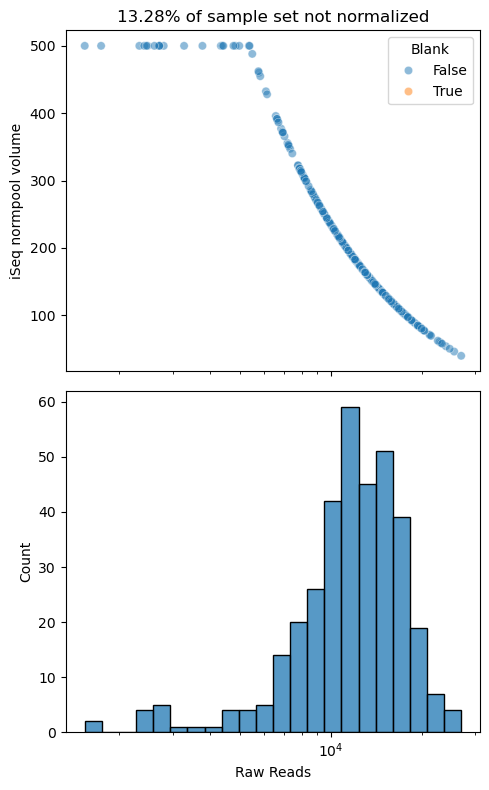

In [78]:
plate_df_normalized = calculate_iseqnorm_pooling_volumes(plate_df_w_reads,dynamic_range=5, normalization_column='Raw Reads')

Pool concentration: 3.04
Pool volume: 77561.11


/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1051: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.flatten()[~np.isnan(dataset.flatten())], ax=ax4,


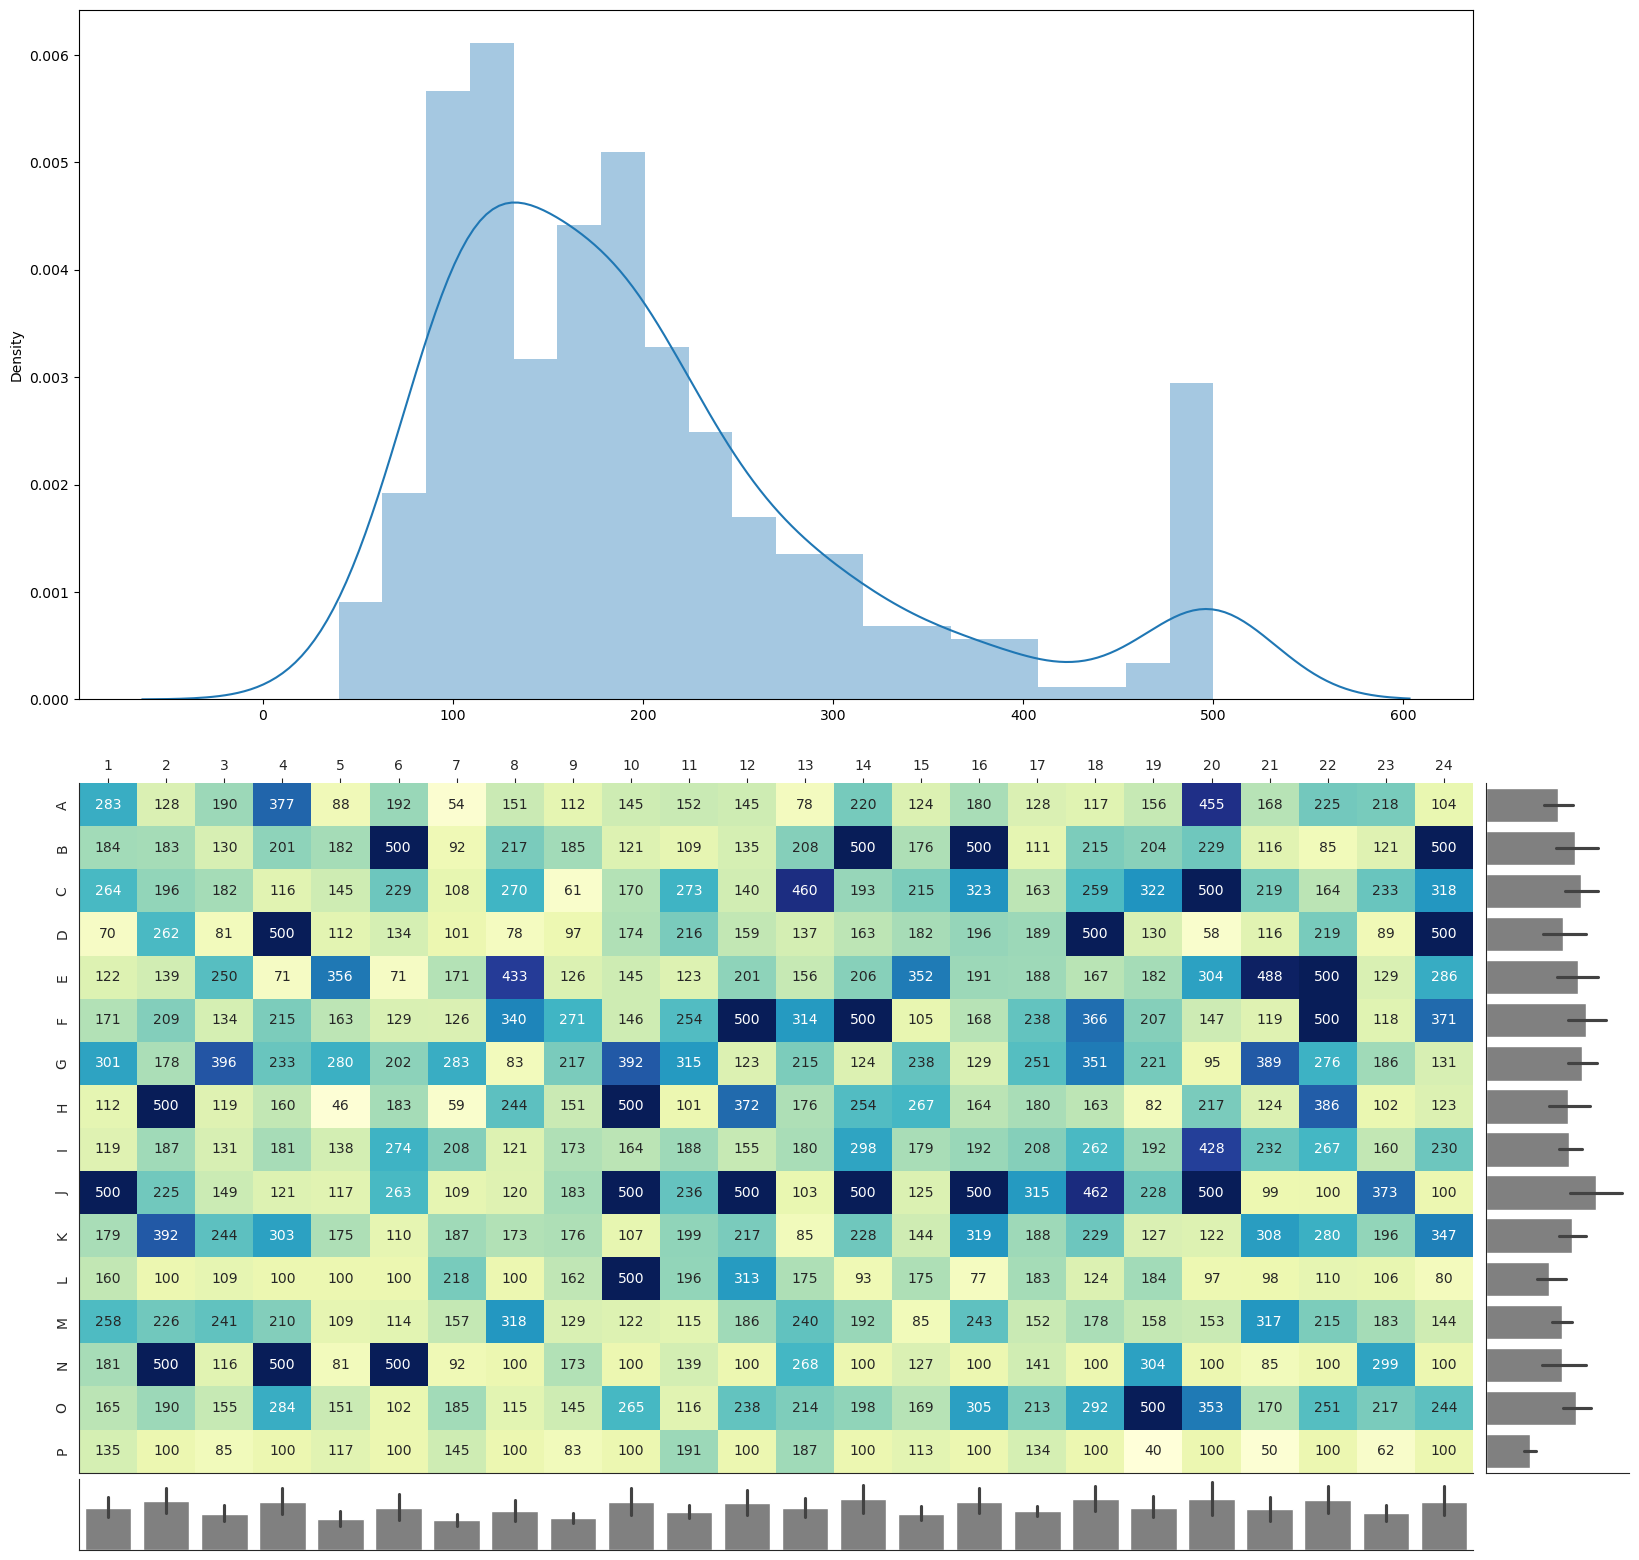

In [79]:
# visualize
vols = make_2D_array(plate_df_normalized, data_col='iSeq normpool volume', well_col=well_col).astype(float)
conc, vol = estimate_pool_conc_vol(plate_df_normalized['iSeq normpool volume'], plate_df_normalized['MiniPico Library Concentration'])
print("Pool concentration: {:.2f}".format(conc))
print("Pool volume: {:.2f}".format(vol))
with suppress(np.linalg.LinAlgError):
    plot_plate_vals(vols)

#### Part 4 of 4, Step 3 of 4: Estimate read depth

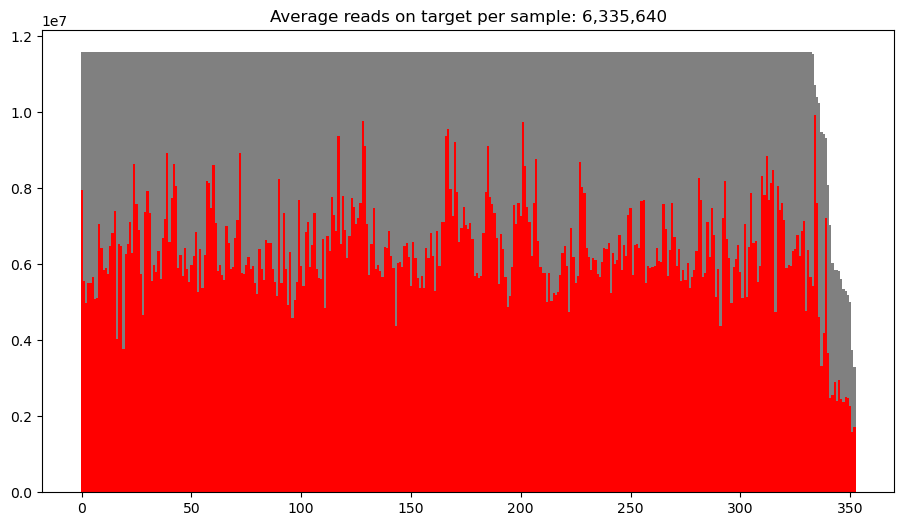

In [80]:
#Plots estimate of read depth proportion, and returns a df with estimates. 
plate_df_normalized_with_estimates = estimate_read_depth(plate_df_normalized)

#### Part 4 of 4, Step 4 of 4: Make pooling picklist and write to a file

In [81]:
iseqnormed_picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)

In [82]:
# Write the picklist as .csv
iseqnormed_picklist_fp = './test_output/Pooling/YYYY_MM_DD_Celeste_Adaptation_16_17_18_21_iSeqnormpool.csv'

if os.path.isfile(iseqnormed_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [83]:
with open(iseqnormed_picklist_fp,'w') as f:
    f.write(iseqnormed_picklist)

!head {iseqnormed_picklist_fp}

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2,A1,,283.48,NormalizedDNA,A1
1,384LDV_AQ_B2,A2,,127.74,NormalizedDNA,A1
1,384LDV_AQ_B2,A3,,190.23,NormalizedDNA,A1
1,384LDV_AQ_B2,A4,,377.21,NormalizedDNA,A1
1,384LDV_AQ_B2,A5,,87.85,NormalizedDNA,A1
1,384LDV_AQ_B2,A6,,191.56,NormalizedDNA,A1
1,384LDV_AQ_B2,A7,,54.23,NormalizedDNA,A1
1,384LDV_AQ_B2,A8,,151.37,NormalizedDNA,A1
1,384LDV_AQ_B2,A9,,111.56,NormalizedDNA,A1
